In [1]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()


# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..')) #NOTE: if copying this then be aware of .. usage REMOVE
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
from tueplots import bundles
import matplotlib.pyplot as plt
import src.BikeDataPlotter as BikePlotter
import src.EventsDataPlotter as EventsPlotter
import src.Colortheme as ct
import importlib

import src.BikeSeasonalDecomposition as BikeDecomp
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from src.LoadEventsData import EventsData
from src.LoadEcoCounterData import EcoCounterData as BikeData

In [2]:
bd = BikeData()
ed = EventsData()

In [3]:
bike_data = bd.get_daily_data(None, None, corrected=True, time_as_index=True)

In [4]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})
all_years = [year for year in range(2014, 2024)]

In [5]:
def create_seasonal_decomposition(stylesheet, counter_id=None, years=None, weekly_window=None, 
                                  custom_data=None, residuals=False):
    def set_legend(axes, subs):
        leg_loc = 1.225 if subs==4 else 1.175
        for i,ax in enumerate(axes):
            leg = ax.legend(bbox_to_anchor=(1,leg_loc), ncol=2, loc="upper right", frameon=False, borderaxespad=0.3)
                # leg.get_frame().set_linewidth(0.1)
    importlib.reload(ct)
    importlib.reload(BikePlotter)
    importlib.reload(EventsPlotter)
    
    plt.rcParams.update(stylesheet)
    subs = 4 if residuals else 3
    fig_info = plt.subplots(subs, 1, sharex=False)
    event_axis = fig_info[1][:]
    
    # week_view = weekly_window is not None
    to_process_data = custom_data if custom_data is not None else bike_data
    if weekly_window:
        decomp = BikeDecomp.get_seasonal_decomposition(to_process_data, years=years, counter_id=counter_id, week_view=True,
                                            show_window=weekly_window, corr=custom_data is not None, residuals=residuals)
        # print(decomp)
        BikePlotter.plot_seasonal_decomposition(decomp, fig_info, show_window=weekly_window,
                                                counter_id=counter_id, xtick_format="week")
        
    else:
        decomp = BikeDecomp.get_seasonal_decomposition(to_process_data, years=years, counter_id=counter_id, week_view=False,
                                            show_window=weekly_window, corr=custom_data is not None, residuals=residuals)
        BikePlotter.plot_seasonal_decomposition(decomp, fig_info, counter_id=counter_id, xtick_format="year")
        
    if years is None:
        years = all_years
    # holidays = EventsPlotter.plot_holidays(ed, years, [event_axis])
    if weekly_window is None:
        EventsPlotter.plot_school_breaks(ed, years, event_axis)
        EventsPlotter.plot_covid(ed, years, event_axis, show_abbr=False)
    # EventsPlotter.plot_lecture_period(ed, years, [event_axis])
        set_legend(fig_info[1], subs=subs)
    plt.show()

# Absolute Trend Analysis

The purpose of this evaluation is to depict trends in the eco counter data, that last over all years (2014 - 2023). We analyze the three counters separately and then compare the results. As figured in `eval_001_CounterAnalysis.ipynb` the Hirschau counter data differs mainly from the other two counters. To settle this assumption, we first apply a seasonal decomposition to the data, choosing a period window of 365 days, to receive the __yearly trend__.

School breaks are (ordered by time of year):
- winter break (first and last gray area in the plot)
- carnival ("Fasnacht") break
- easter break
- whitsun ("Pfingsten") break
- summer break
- autumn break

## Fahrradtunnel

- the first plot shows the behaviour analyzed in the previous evaluation
- the second plot shows the yearly trend of the data. It is clearly visible, that the trend is increasing over the years
- the third plot shows the seasonal trend of the data. It is visible that each year has the same pattern as assumed in the previous evaluation, i.e. an increase in the summer months, a short dip during the summer break and a decrease in the winter months. As school breaks like easter and whitsun are not always at the same time, they are not included in the seasonal trend. School breaks might be well detectable in the residuals of a decomposition analysis with a 7-day rolling window
- the residuals show deviations, that are note explainable by trend and season. In this resolution it is hard to tell what could cause these deviations. 
- the residuals will be omitted in the following plots

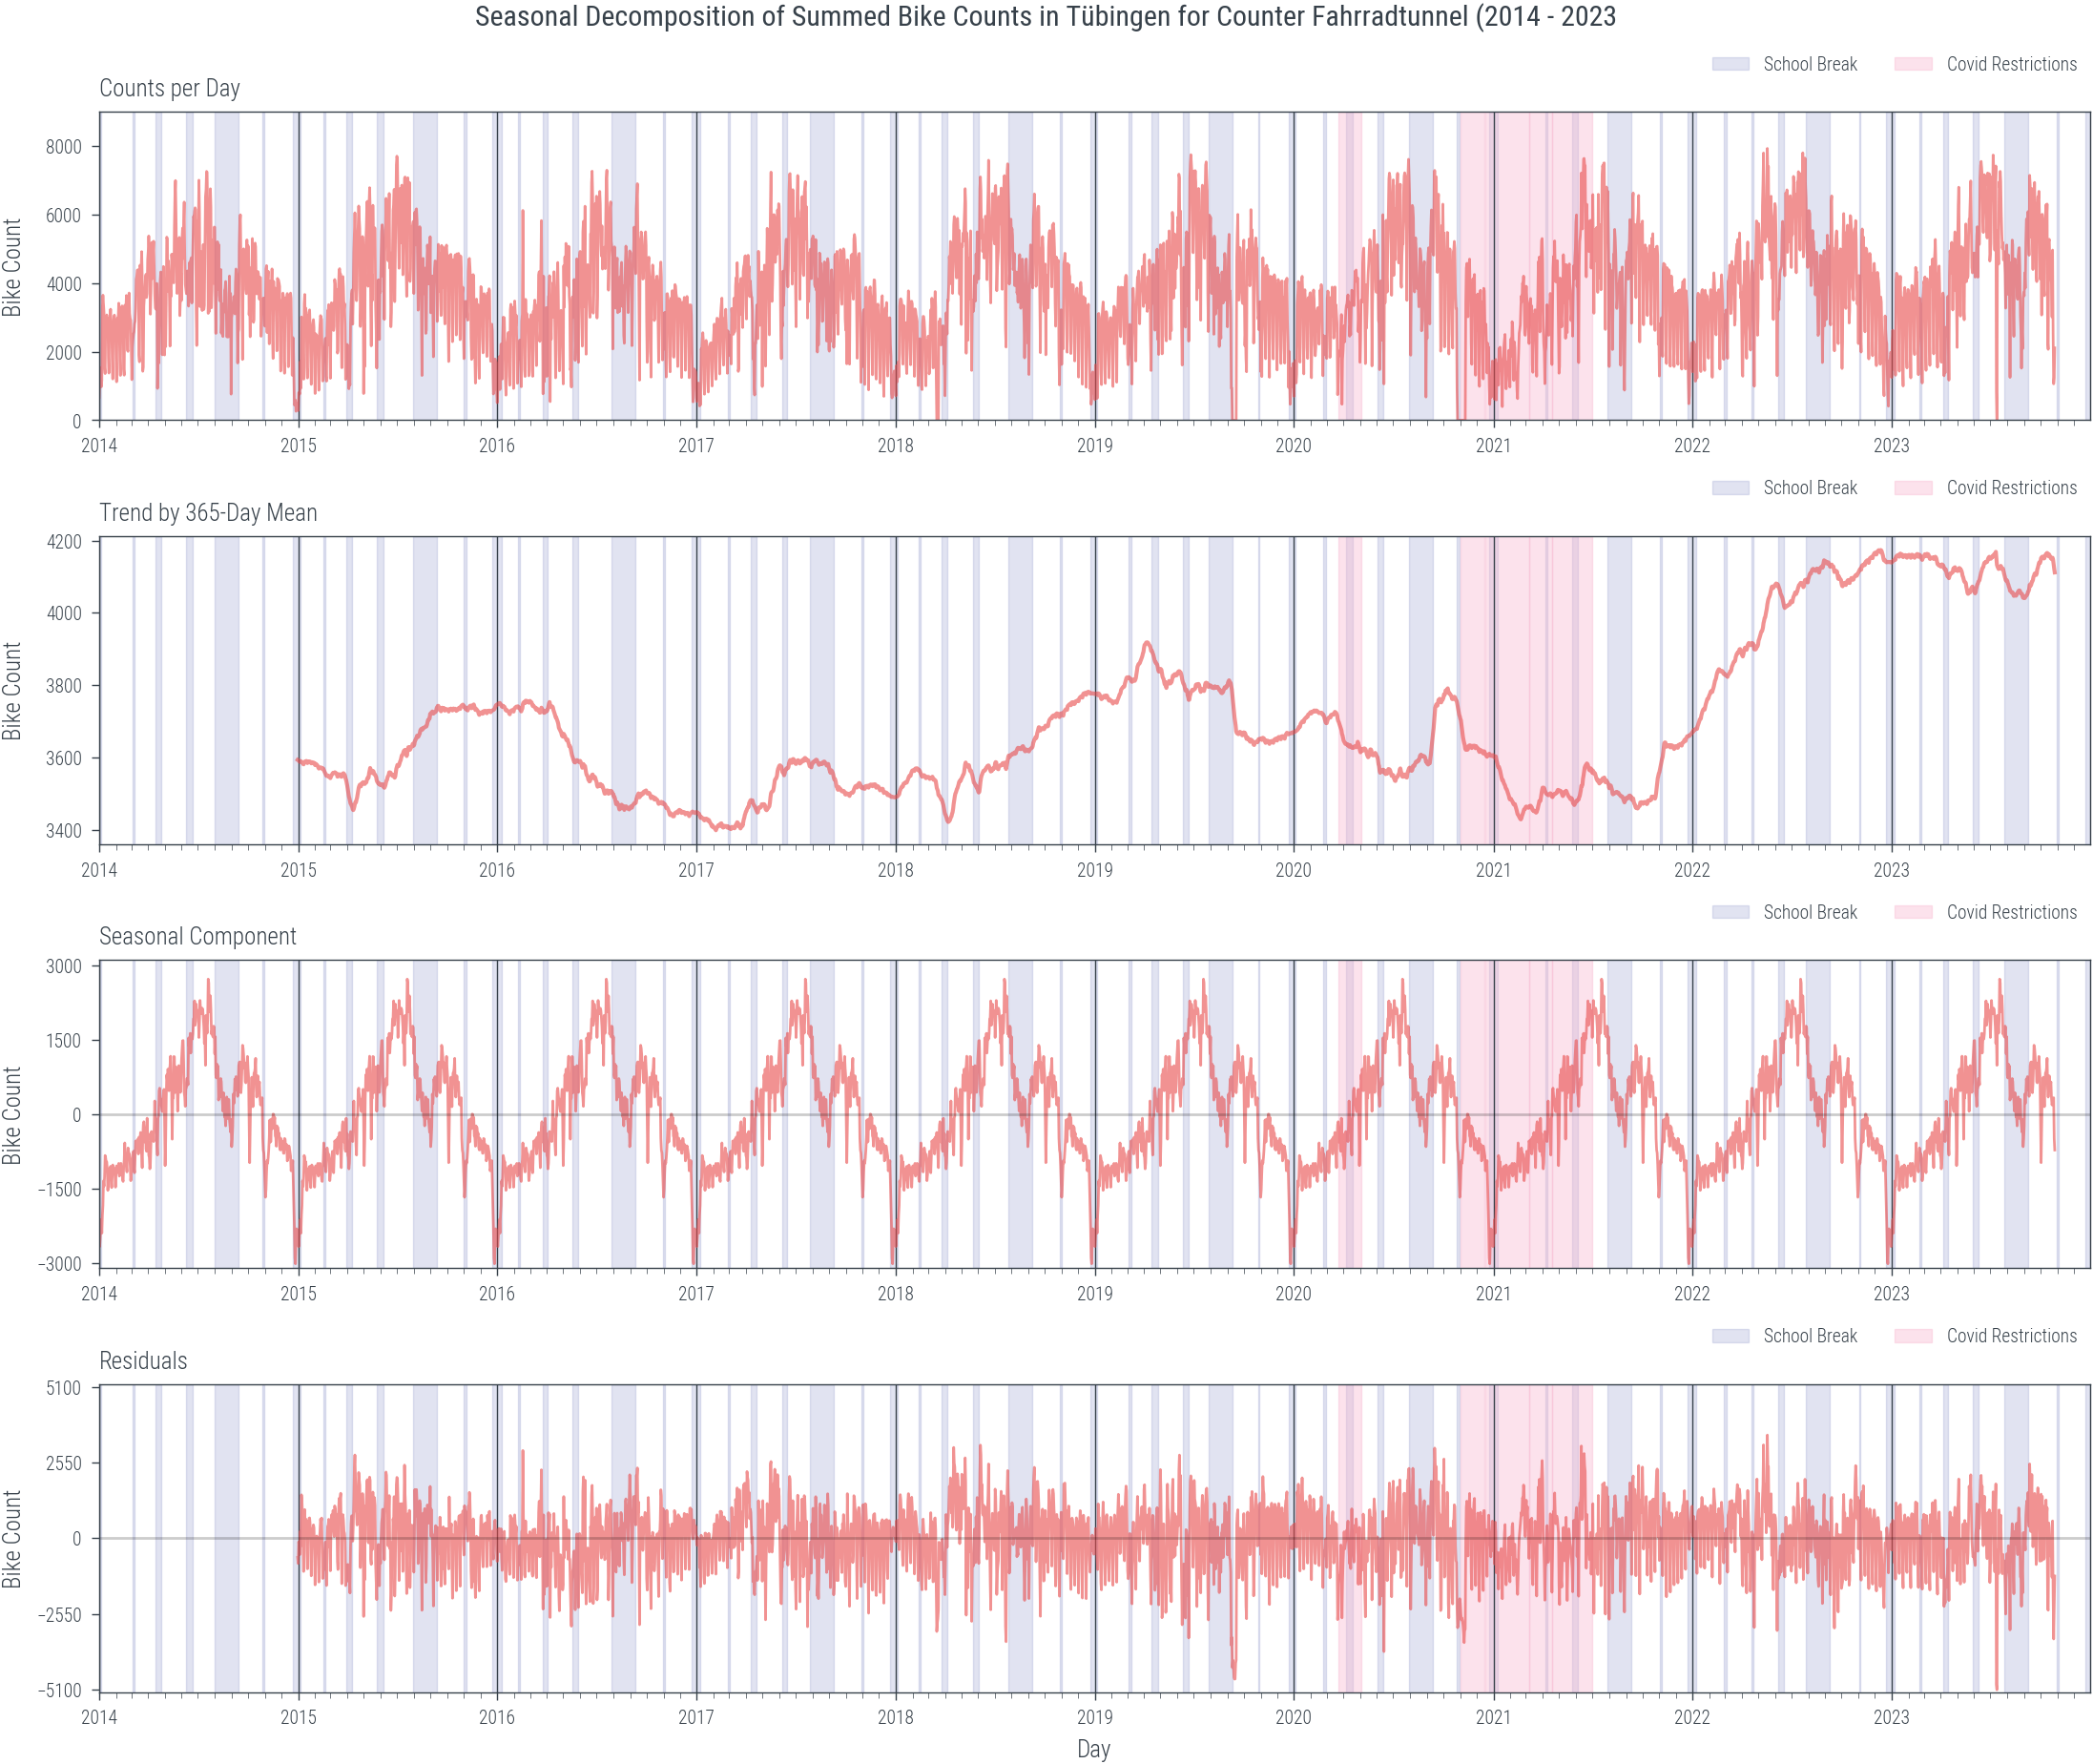

In [6]:
STYLE_4_SUBS= bundles.beamer_moml(rel_width=2, rel_height=3)
create_seasonal_decomposition(STYLE_4_SUBS, counter_id=[100003358], residuals=True)

## Steinlachallee
- for the observed counts and the season the data looks similar to the Fahrradtunnel data. Especially the seasonal trend is very similar
- the trend data increases as well, but there is a huge dip at the end of 2017. This dip is explainable by the long downtime of the counter in winter 2017

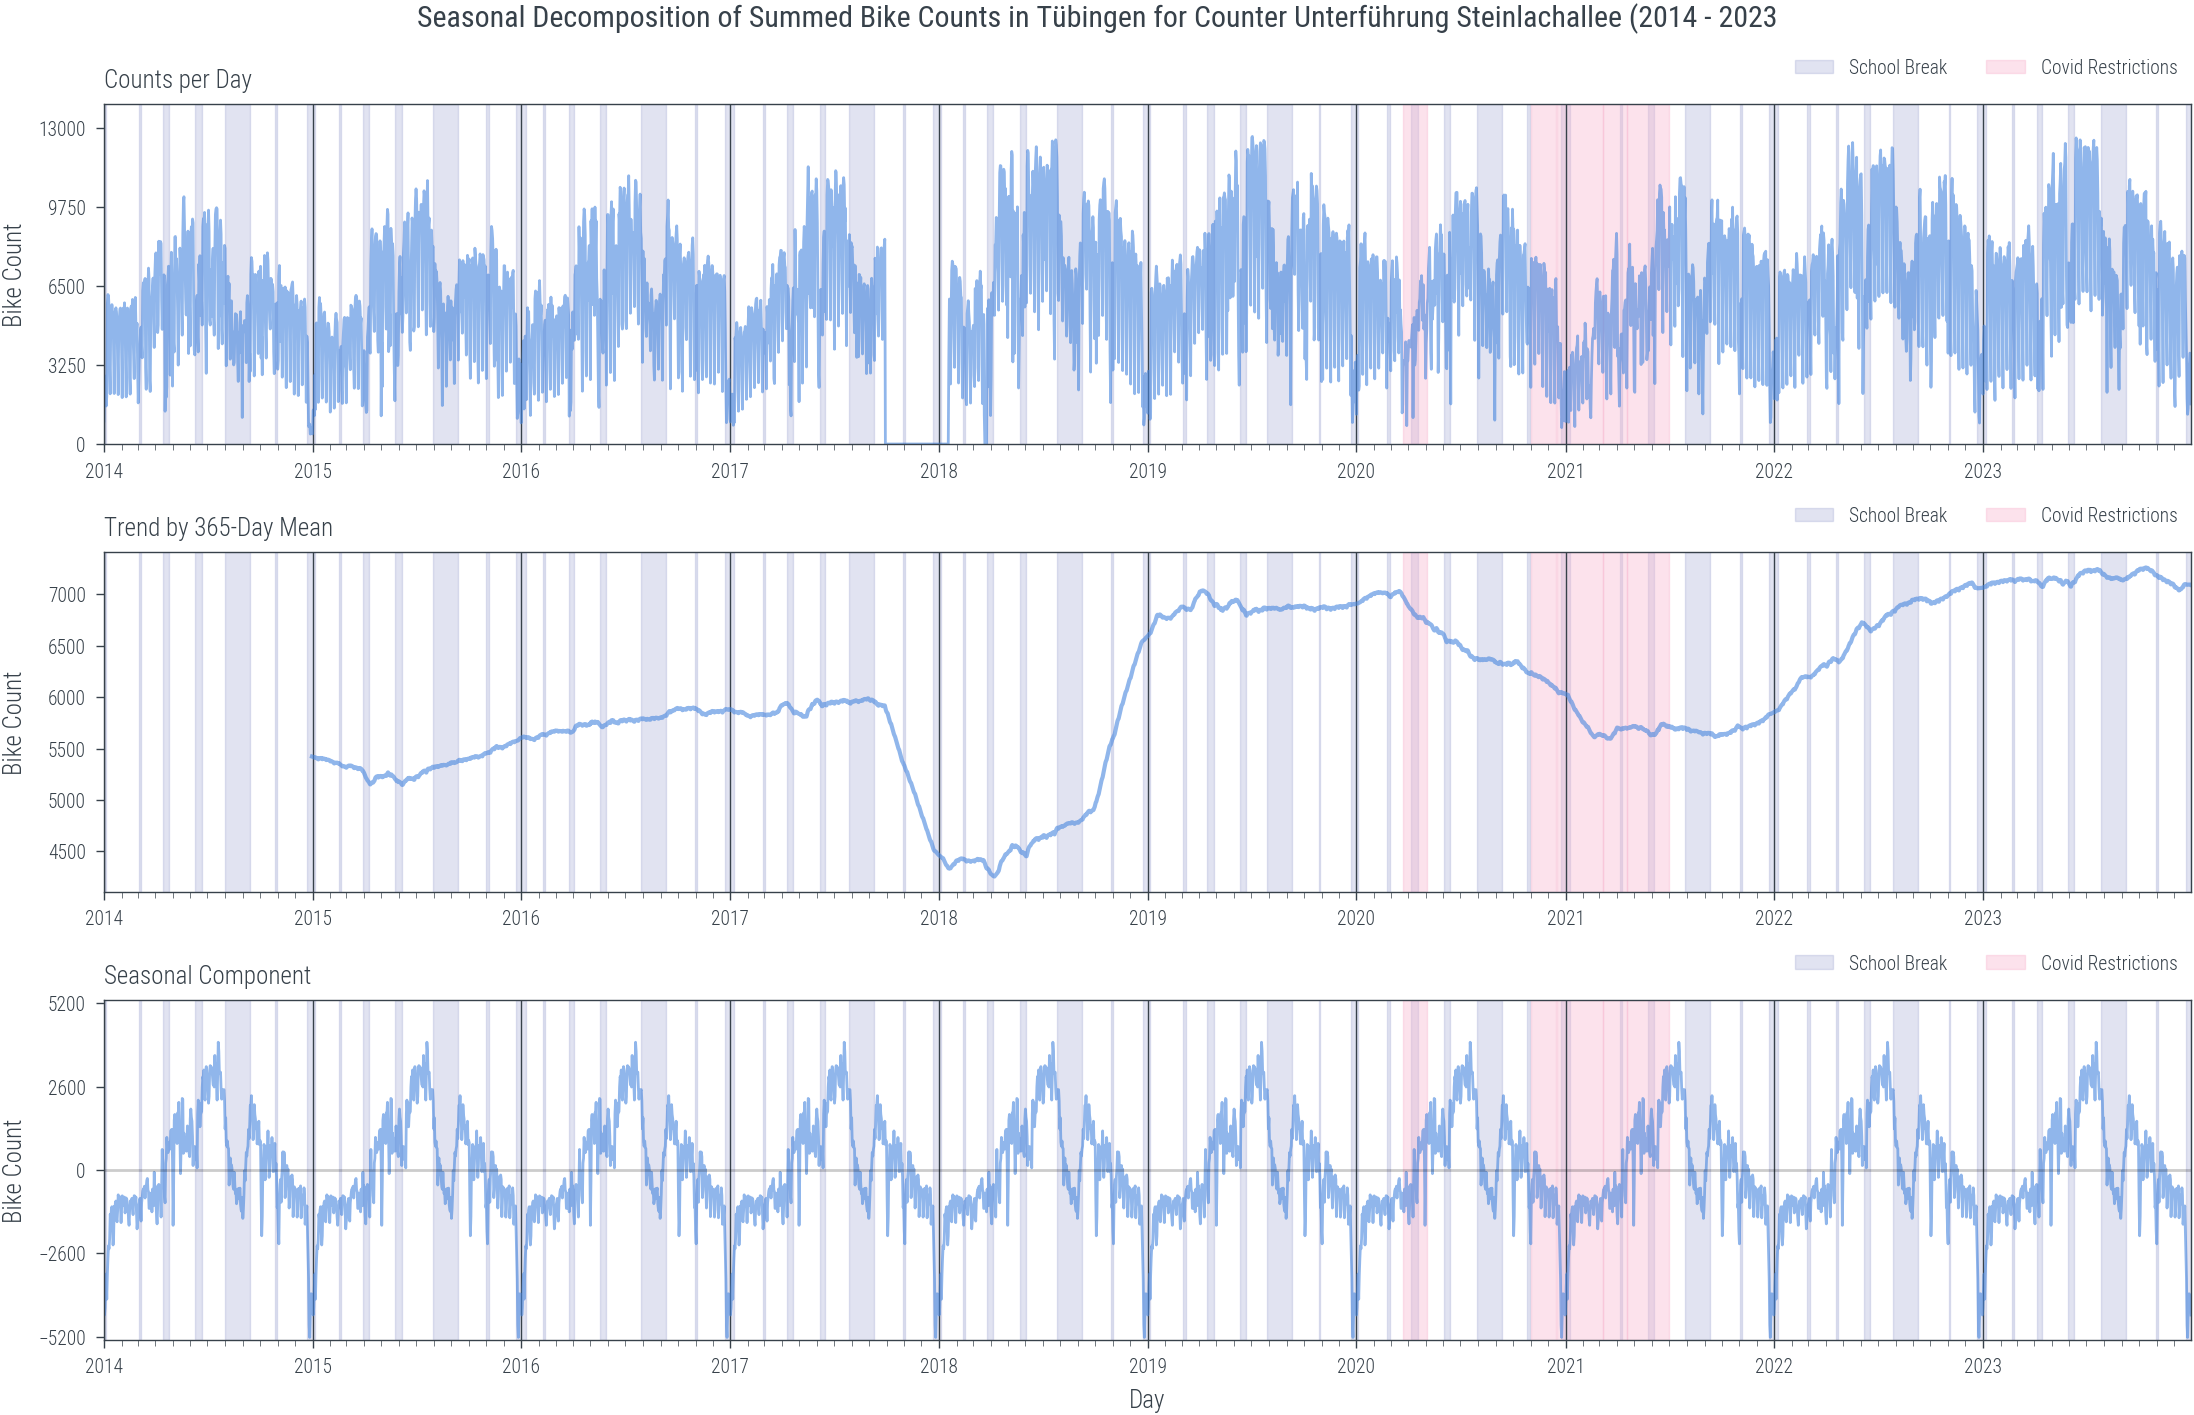

In [7]:
STYLE_3_SUBS = bundles.beamer_moml(rel_width=2, rel_height=2.3)
create_seasonal_decomposition(STYLE_3_SUBS, counter_id=[100003359])

## Hirschau
- Hirschau also shows an increasing trend. Most interesting is the intensified increase starting with the first lockdown on March, 22nd 2020. This might be caused by the contact restrictions that were put in place during the first lockdown. People were allowed to meet only one person outside their household. This might have caused more people to go for a walk or a bike ride with their partner or a friend
- the seasonal trend is focused on summer months and differs strongly from the other two counters. As mentioned previously, this might be caused by the location of the counter


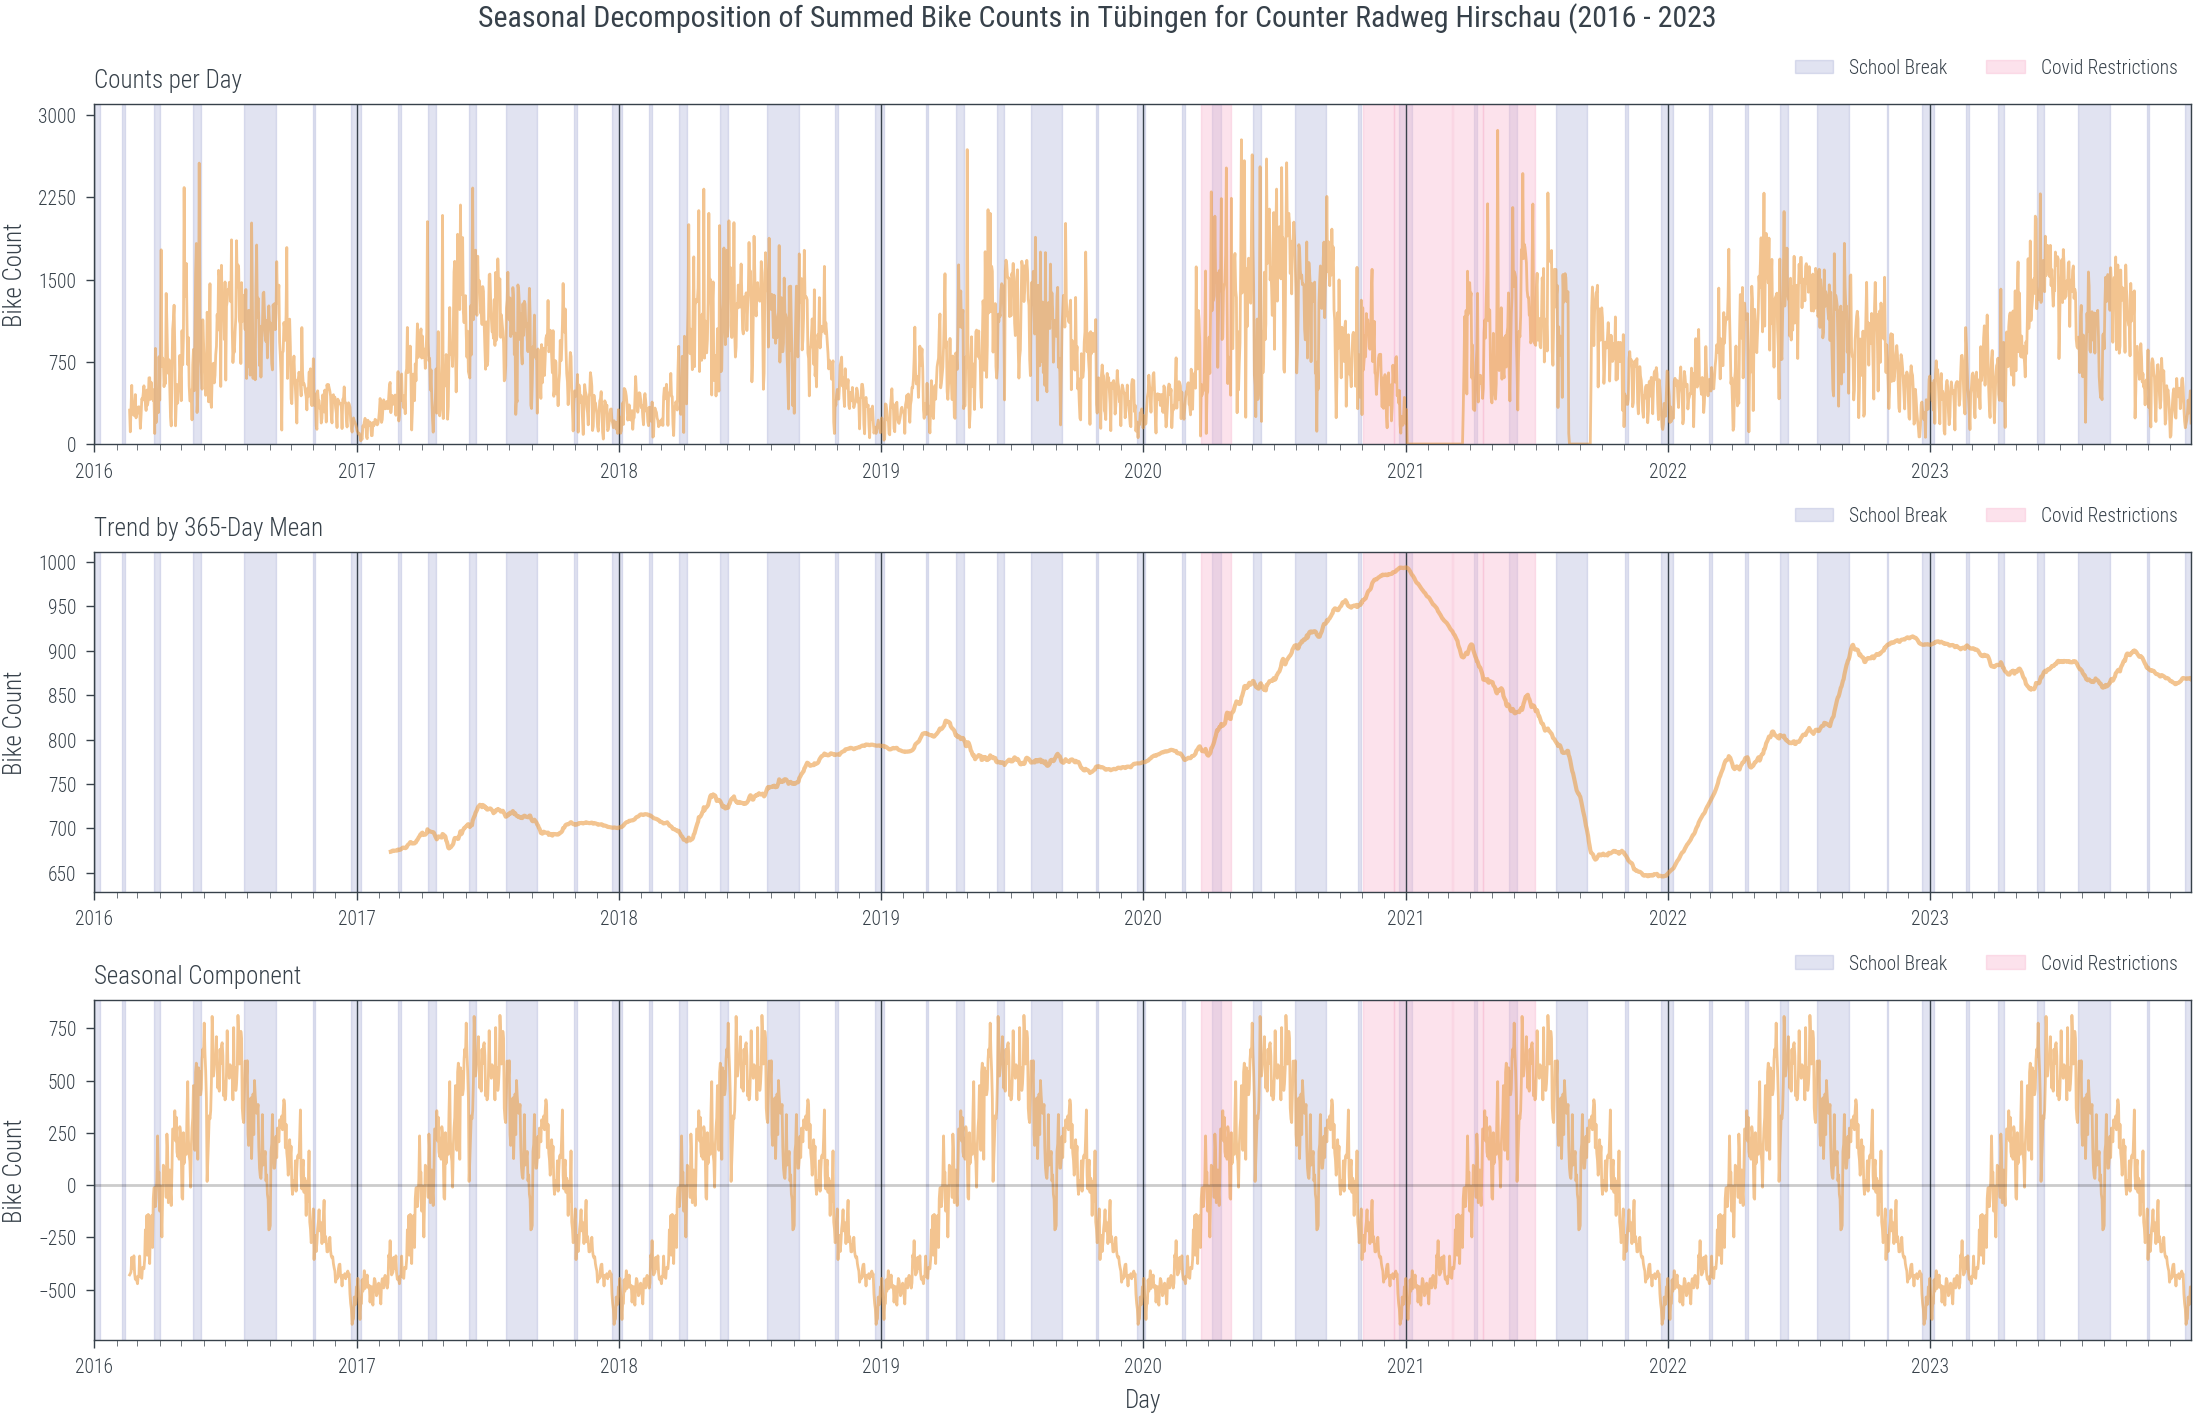

In [8]:
create_seasonal_decomposition(STYLE_3_SUBS, counter_id=[100026408])

## Preparing Counter Correlation Tests

In [9]:
# code for the upcoming tests
daily_bike_data = bd.get_daily_data()
def calc_pearson(data, to_calc): # TODO: make it tab aligned? or nah?
    infos = []
    for i in range(3):
        print(f"Correlating: {to_calc[i][0]} and {to_calc[i][1]}")
        correlation_coefficient, p_value = pearsonr(data[f"{to_calc[i][0]}"], data[f"{to_calc[i][1]}"])
        infos.append([correlation_coefficient, p_value])
        print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
        print(f"P-value: {p_value}")
    return infos

def reset():
    tunnel_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100003358][["iso_timestamp", "zählstand"]]
    steinlach_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100003359][["iso_timestamp", "zählstand"]] 
    hirschau_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100026408][["iso_timestamp", "zählstand"]]
    
    # merge to get data that all counters have in common
    df_data = tunnel_df.merge(steinlach_df, on='iso_timestamp', how='inner', suffixes=('_tunnel', '_steinlach')).merge(hirschau_df, on='iso_timestamp', how='inner')
    df_data.rename(columns={"zählstand": "zählstand_hirschau"}, inplace=True)
    return df_data

def standardize(df_data):
    df_data['zählstand_tunnel'] = (df_data['zählstand_tunnel'] - df_data['zählstand_tunnel'].mean()) / (df_data['zählstand_tunnel'].std())
    df_data['zählstand_steinlach'] = (df_data['zählstand_steinlach'] - df_data['zählstand_steinlach'].mean()) / (df_data['zählstand_steinlach'].std())
    df_data['zählstand_hirschau'] = (df_data['zählstand_hirschau'] - df_data['zählstand_hirschau'].mean()) / (df_data['zählstand_hirschau'].std())
    return df_data
    
def normalize(df_data):
    df_data['zählstand_tunnel'] = df_data['zählstand_tunnel'] / df_data['zählstand_tunnel'].max()
    df_data['zählstand_steinlach'] = df_data['zählstand_steinlach'] / df_data['zählstand_steinlach'].max()
    df_data['zählstand_hirschau'] = df_data['zählstand_hirschau'] / df_data['zählstand_hirschau'].max()
    return df_data
    
def min_max_feature_scaling(df_data):
    df_data['zählstand_tunnel'] = (df_data['zählstand_tunnel'] - df_data['zählstand_tunnel'].min()) / (df_data['zählstand_tunnel'].max() - df_data['zählstand_tunnel'].min())
    df_data['zählstand_steinlach'] = (df_data['zählstand_steinlach'] - df_data['zählstand_steinlach'].min()) / (df_data['zählstand_steinlach'].max() - df_data['zählstand_steinlach'].min())
    df_data['zählstand_hirschau'] = (df_data['zählstand_hirschau'] - df_data['zählstand_hirschau'].min()) / (df_data['zählstand_hirschau'].max() - df_data['zählstand_hirschau'].min())
    return df_data

comp_pairs = [["zählstand_tunnel", "zählstand_steinlach"], ["zählstand_tunnel", "zählstand_hirschau"], ["zählstand_steinlach", "zählstand_hirschau"]]
merged_bike_data = reset()
merged_bike_data.head()

iso_timestamp  zählstand_tunnel  zählstand_steinlach  zählstand_hirschau
0    2016-02-19              2805                 4997                 309
1    2016-02-20              1485                 3055                 111
2    2016-02-21              1278                 2252                 316
3    2016-02-22              3530                 6051                 535
4    2016-02-23              2610                 4446                 275

# Is there a Correlation between the Counters?

In the following, the normalized timeseries of the counters are compared in a plot. We use normalization as the average counts at all three counters differ significantly (compare table in eval_001_SA). 


We assume the trends of Fahrradtunnel and Steinlachallee to be similar, as they are located in the city center. The trend of Hirschau is expected to differ from the other two counters, as it is located farther outside the city. To verify this assumption we first compute the correlation between the counters. For this kind of analysis we only use days, which are available in all three timeseries to get no influences by downtimes of counters.

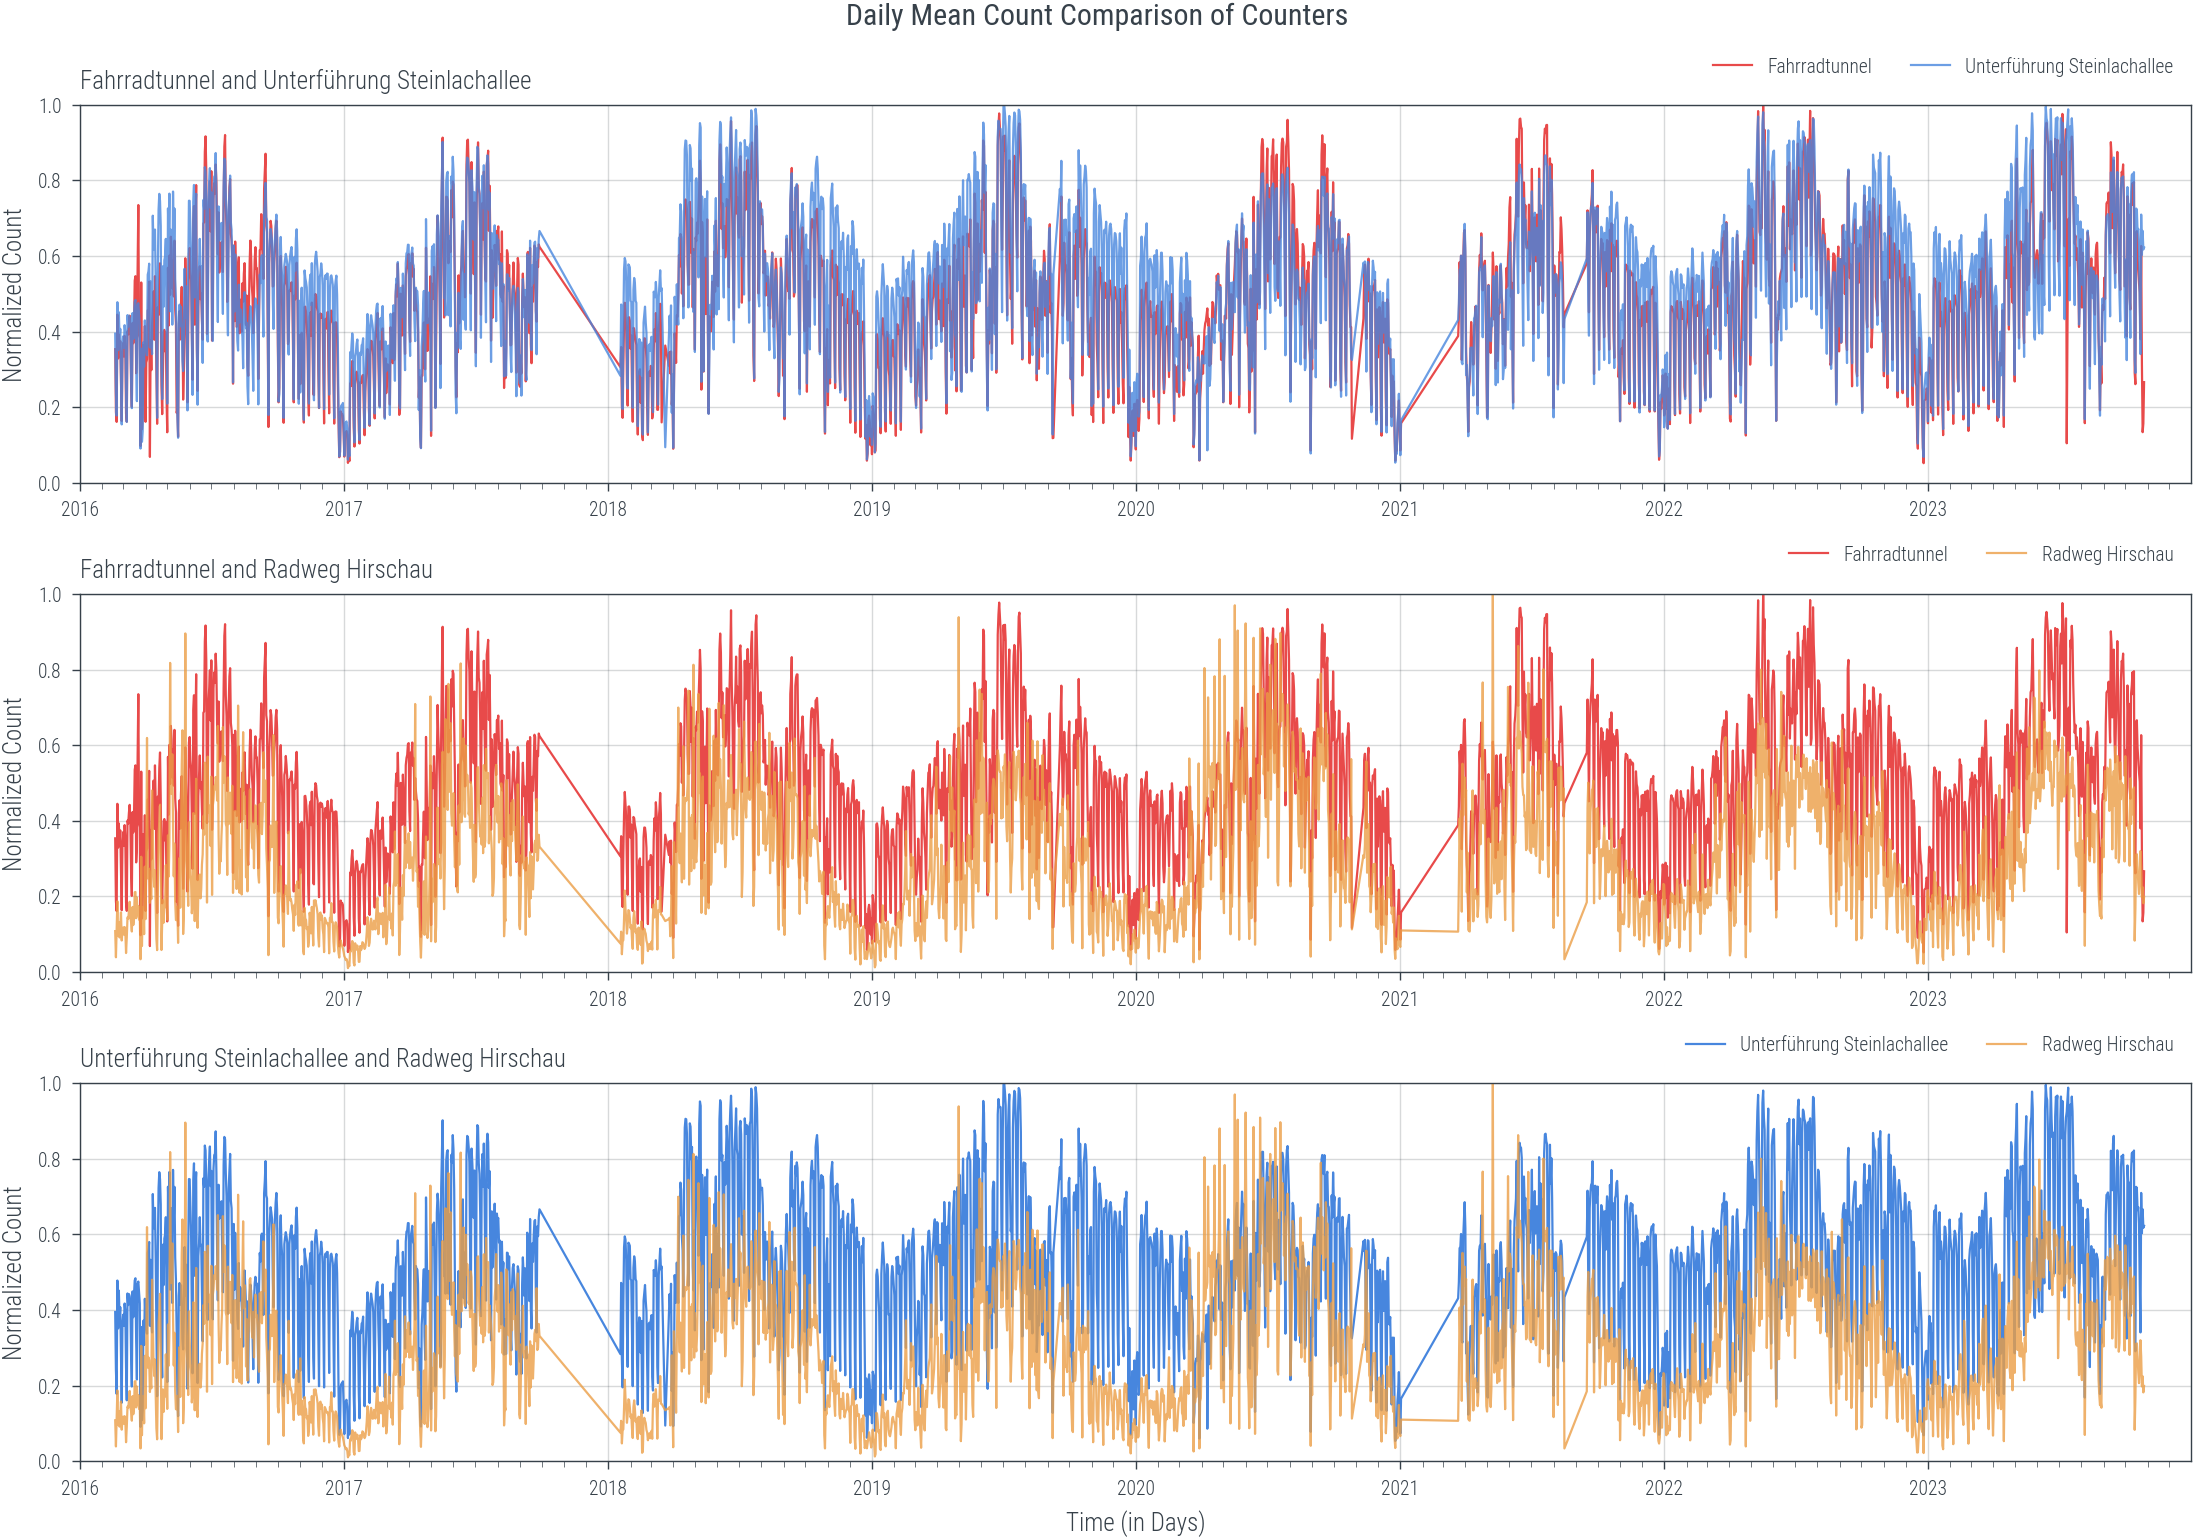

In [21]:
df_data_normalized = normalize(merged_bike_data)

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=2.5))
fig, ax = plt.subplots(3, 1)
labels = [["Fahrradtunnel","Unterführung Steinlachallee"],["Fahrradtunnel","Radweg Hirschau"], ["Unterführung Steinlachallee","Radweg Hirschau"]]
color_mapping = { #TODO: Question COLOR COUNTERS or 2 MAIN ONES
    "Fahrradtunnel":   0,
    "Unterführung Steinlachallee":   1,
    "Radweg Hirschau":   2,
}
lw=.8
for idx, pair in enumerate(comp_pairs):
    ax[idx].plot(
        df_data_normalized["iso_timestamp"],
        df_data_normalized[pair[0]],
        label=labels[idx][0],
        color=BikePlotter.COUNTER[BikePlotter.COUNTER_ORDER[color_mapping[labels[idx][0]]]]["color"],
        lw=lw
    )
    ax[idx].plot(
        df_data_normalized["iso_timestamp"],
        df_data_normalized[pair[1]],
        label=labels[idx][1],
        color=BikePlotter.COUNTER[BikePlotter.COUNTER_ORDER[color_mapping[labels[idx][1]]]]["color"],
        alpha=0.8,
        lw=lw
    )
    ax[idx].set_ylabel('Normalized Count')
    ax[idx].grid()
    ax[idx].legend(bbox_to_anchor=(1,1.175), ncol=2, loc="upper right", frameon=False) # TODO: add thicker legend  lines
    ax[idx].set_ylim(0, 1)
    ax[idx].set_title(f"{labels[idx][0]} and {labels[idx][1]}", loc="left")
    ax[idx].set_xlim([pd.Timestamp("2016-01-01"), pd.Timestamp("2023-12-31")])
    ax[idx].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax[-1].set_xlabel('Time (in Days)')
# fig.text(-0.01, 0.5, 'Normalized Count', va='center', rotation='vertical'
fig.suptitle("Daily Mean Count Comparison of Counters")
fig.align_labels()
plt.show()

__Observation:__
By visual analysis, we can see that Fahrradtunnel and Steinlachalle overlay in their trend and may correlate strongly. The trend of Hirschau differs from the other two counters, as it is shifted downwards due to higher deviations in the data, but appear to follow the same trend. We perform a Pearson correlation analysis to verify this assumption.

In [11]:
calc_pearson(merged_bike_data, comp_pairs);

Correlating: zählstand_tunnel and zählstand_steinlach
Pearson Correlation Coefficient: 0.913881449749643
P-value: 0.0
Correlating: zählstand_tunnel and zählstand_hirschau
Pearson Correlation Coefficient: 0.7572723198988573
P-value: 0.0
Correlating: zählstand_steinlach and zählstand_hirschau
Pearson Correlation Coefficient: 0.5219917849029134
P-value: 9.783246990806628e-179


We observe a correlation coefficient of 0.91 between Fahrradtunnel and Steinlachallee which indicates a very strong correlation. The correlation coefficient between Fahrradtunnel and Hirschau is strong with 0.76 and the correlation coefficient between Steinlachallee and Hirschau is moderate with 0.52.  

## Difference of Seasonal Components

It would be interesting to know, how strong the seasonal component of the different counters for a period of 365 days correlate. We use the merged data from above.

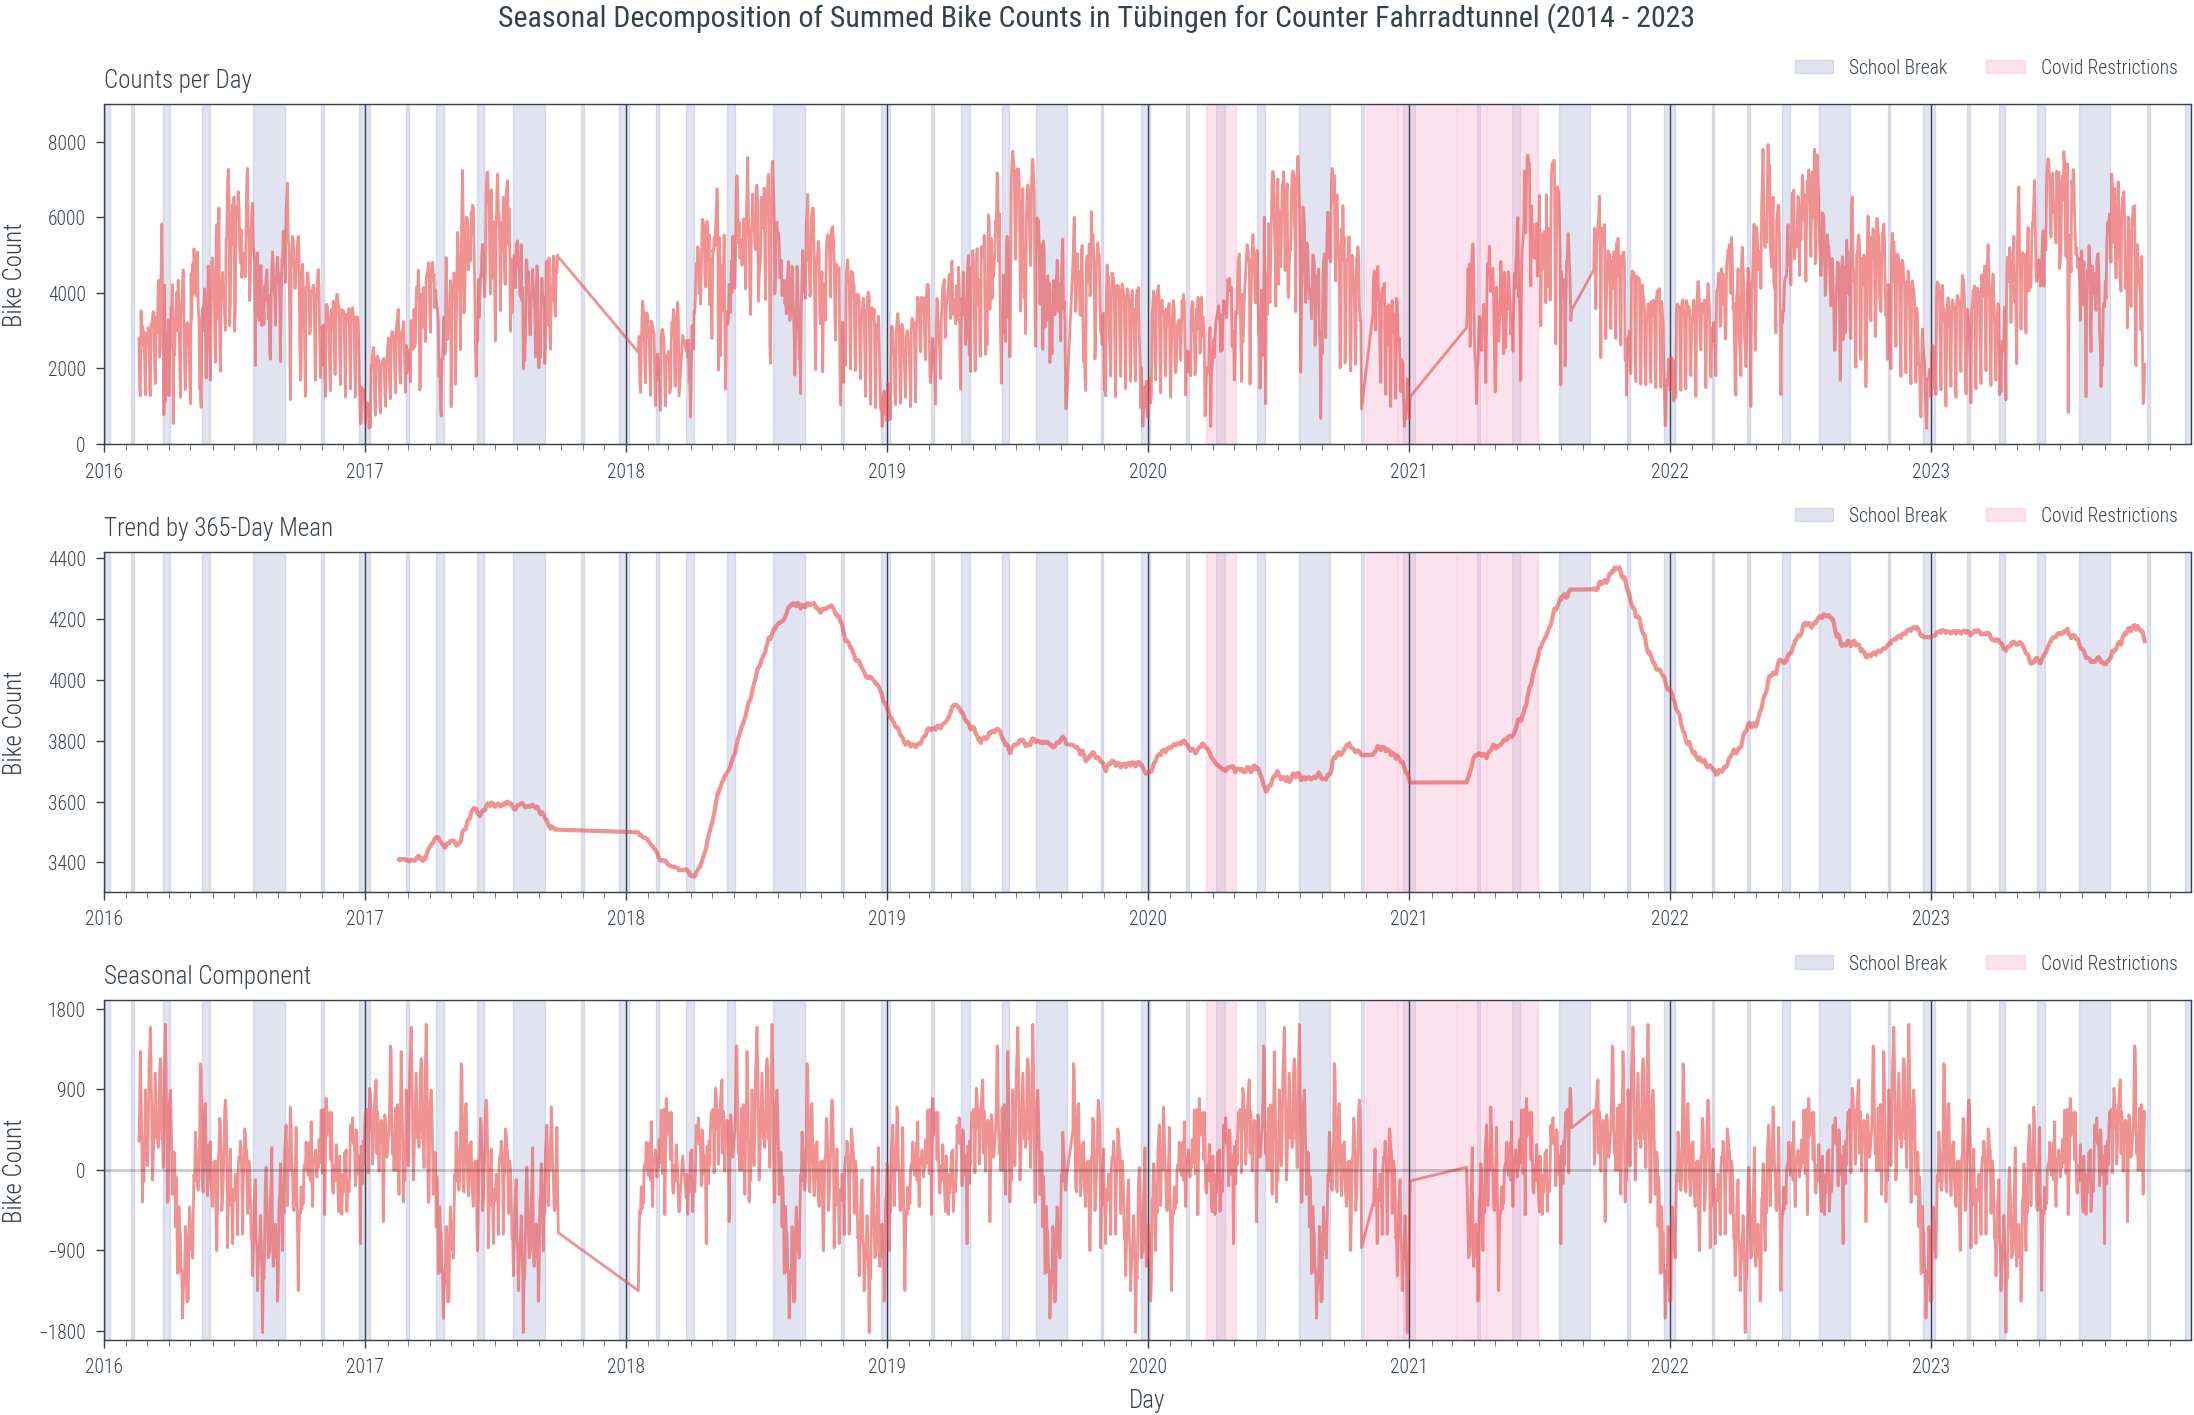

In [12]:
merged_bike_data = reset()
create_seasonal_decomposition(STYLE_3_SUBS, [100003358], custom_data=merged_bike_data)

We check the seasonal components for correlation. As residuals and trend are removed from the data, the correlation coefficient must change somehow.

In [13]:
components_tunnel = seasonal_decompose(merged_bike_data["zählstand_tunnel"], model='additive', period=365, two_sided=False)
components_steinlachallee = seasonal_decompose(merged_bike_data["zählstand_steinlach"], model='additive', period=365, two_sided=False)
components_hirschau = seasonal_decompose(merged_bike_data["zählstand_hirschau"], model='additive', period=365, two_sided=False)

cc_tunnel_steinlach, p_tunnel_steinlach = pearsonr(components_tunnel.seasonal, components_steinlachallee.seasonal)
cc_tunnel_hirschau, p_tunnel_hirschau = pearsonr(components_tunnel.seasonal, components_hirschau.seasonal)
cc_steinlach_hirschau, p_steinlach_hirschau = pearsonr(components_steinlachallee.seasonal, components_hirschau.seasonal)

print(f"Pearson Correlation Coefficient between Fahrradtunnel and Steinlachallee:\t\t{cc_tunnel_steinlach}\t p-value: {p_tunnel_steinlach}")
print(f"Pearson Correlation Coefficient between Fahrradtunnel and Hirschau:\t\t\t{cc_tunnel_hirschau}\t p-value: {p_tunnel_hirschau}")
print(f"Pearson Correlation Coefficient between Steinlachallee and Hirschau\t\t\t{cc_steinlach_hirschau}\t p-value: {p_steinlach_hirschau}")

Pearson Correlation Coefficient between Fahrradtunnel and Steinlachallee:		0.9331570612744851	 p-value: 0.0
Pearson Correlation Coefficient between Fahrradtunnel and Hirschau:			0.7215007348935888	 p-value: 0.0
Pearson Correlation Coefficient between Steinlachallee and Hirschau			0.5122449459694919	 p-value: 4.298391591841107e-171


__Observation:__
- the correlation coefficient between Fahrradtunnel and Steinlachallee seasonal components is 0.93, which indicates a very strong correlation of the yearly pattern and is higher than the correlation coefficient of the observed data 
- for the comparison with the Hirschau seasonal component, the correlation coefficients decrease slightly

Now we reduce the period window to 7 days, to receive a __weekly trend__.

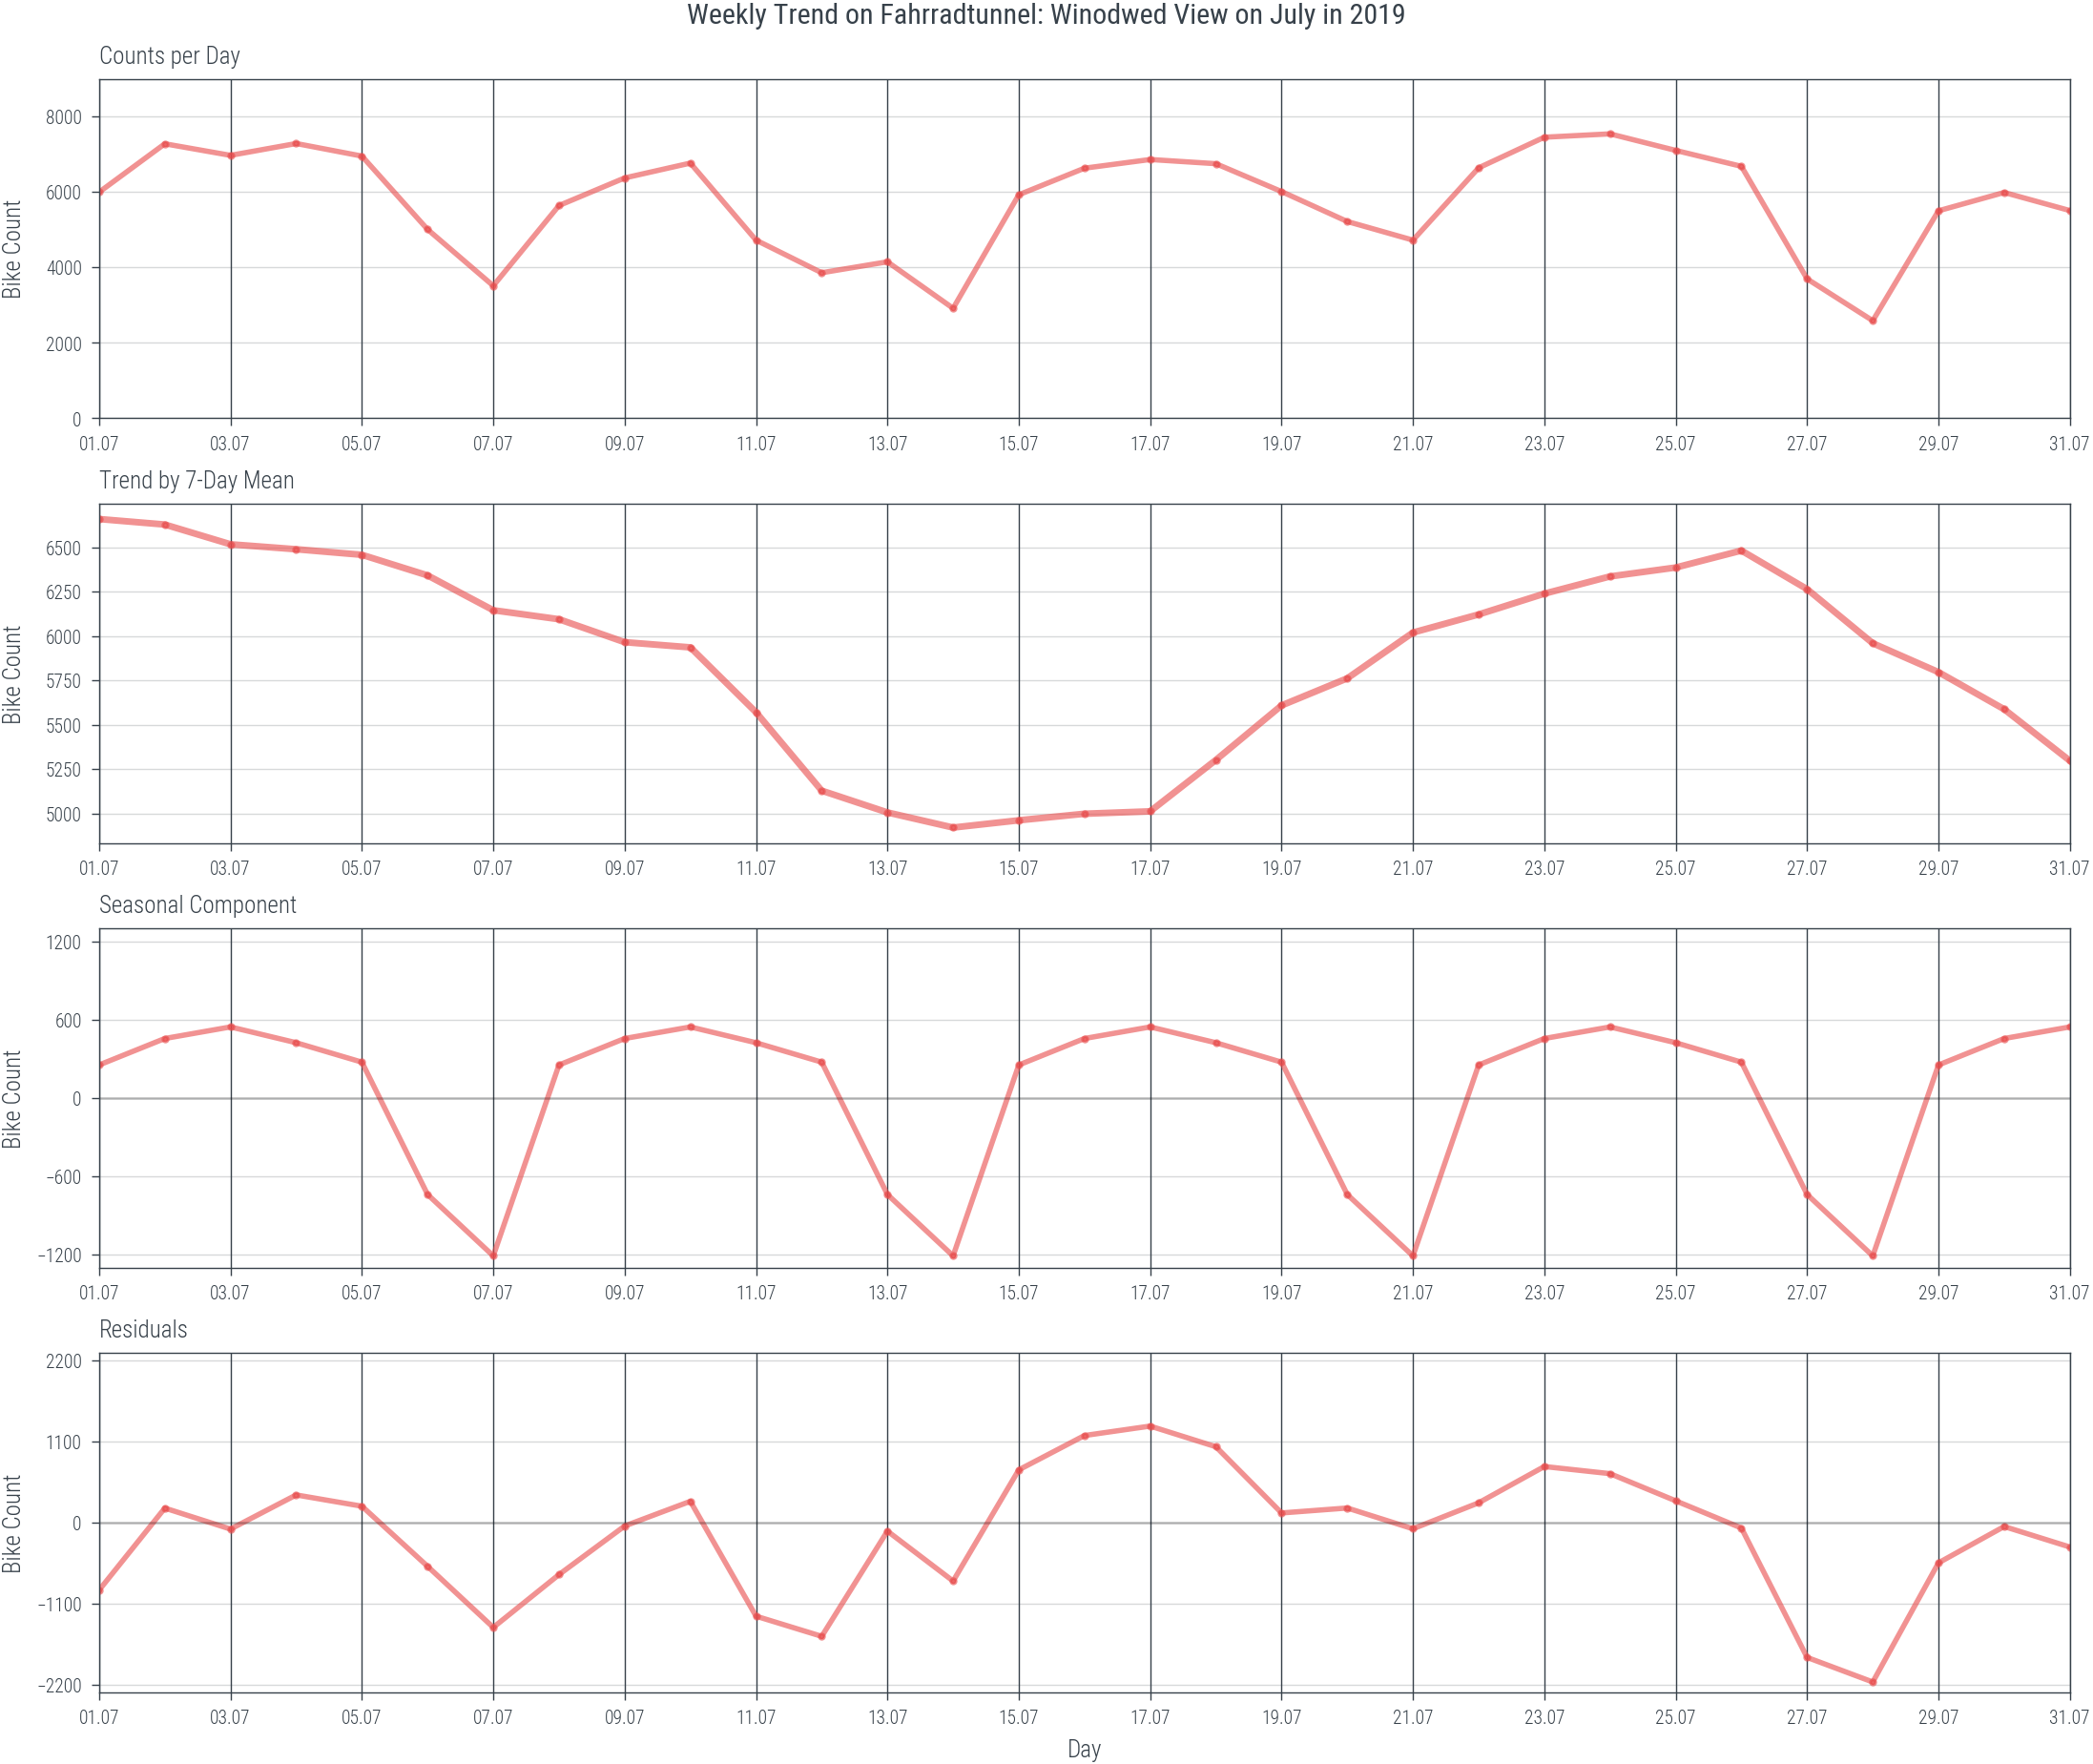

In [14]:
# Fahrradtunnel
month_to_look_at = [pd.Timestamp('2019-07-01'), pd.Timestamp('2019-7-31')]
create_seasonal_decomposition(STYLE_4_SUBS, counter_id=[100003358], weekly_window=month_to_look_at, residuals=True)
# TODO: use ylim on trend or not?

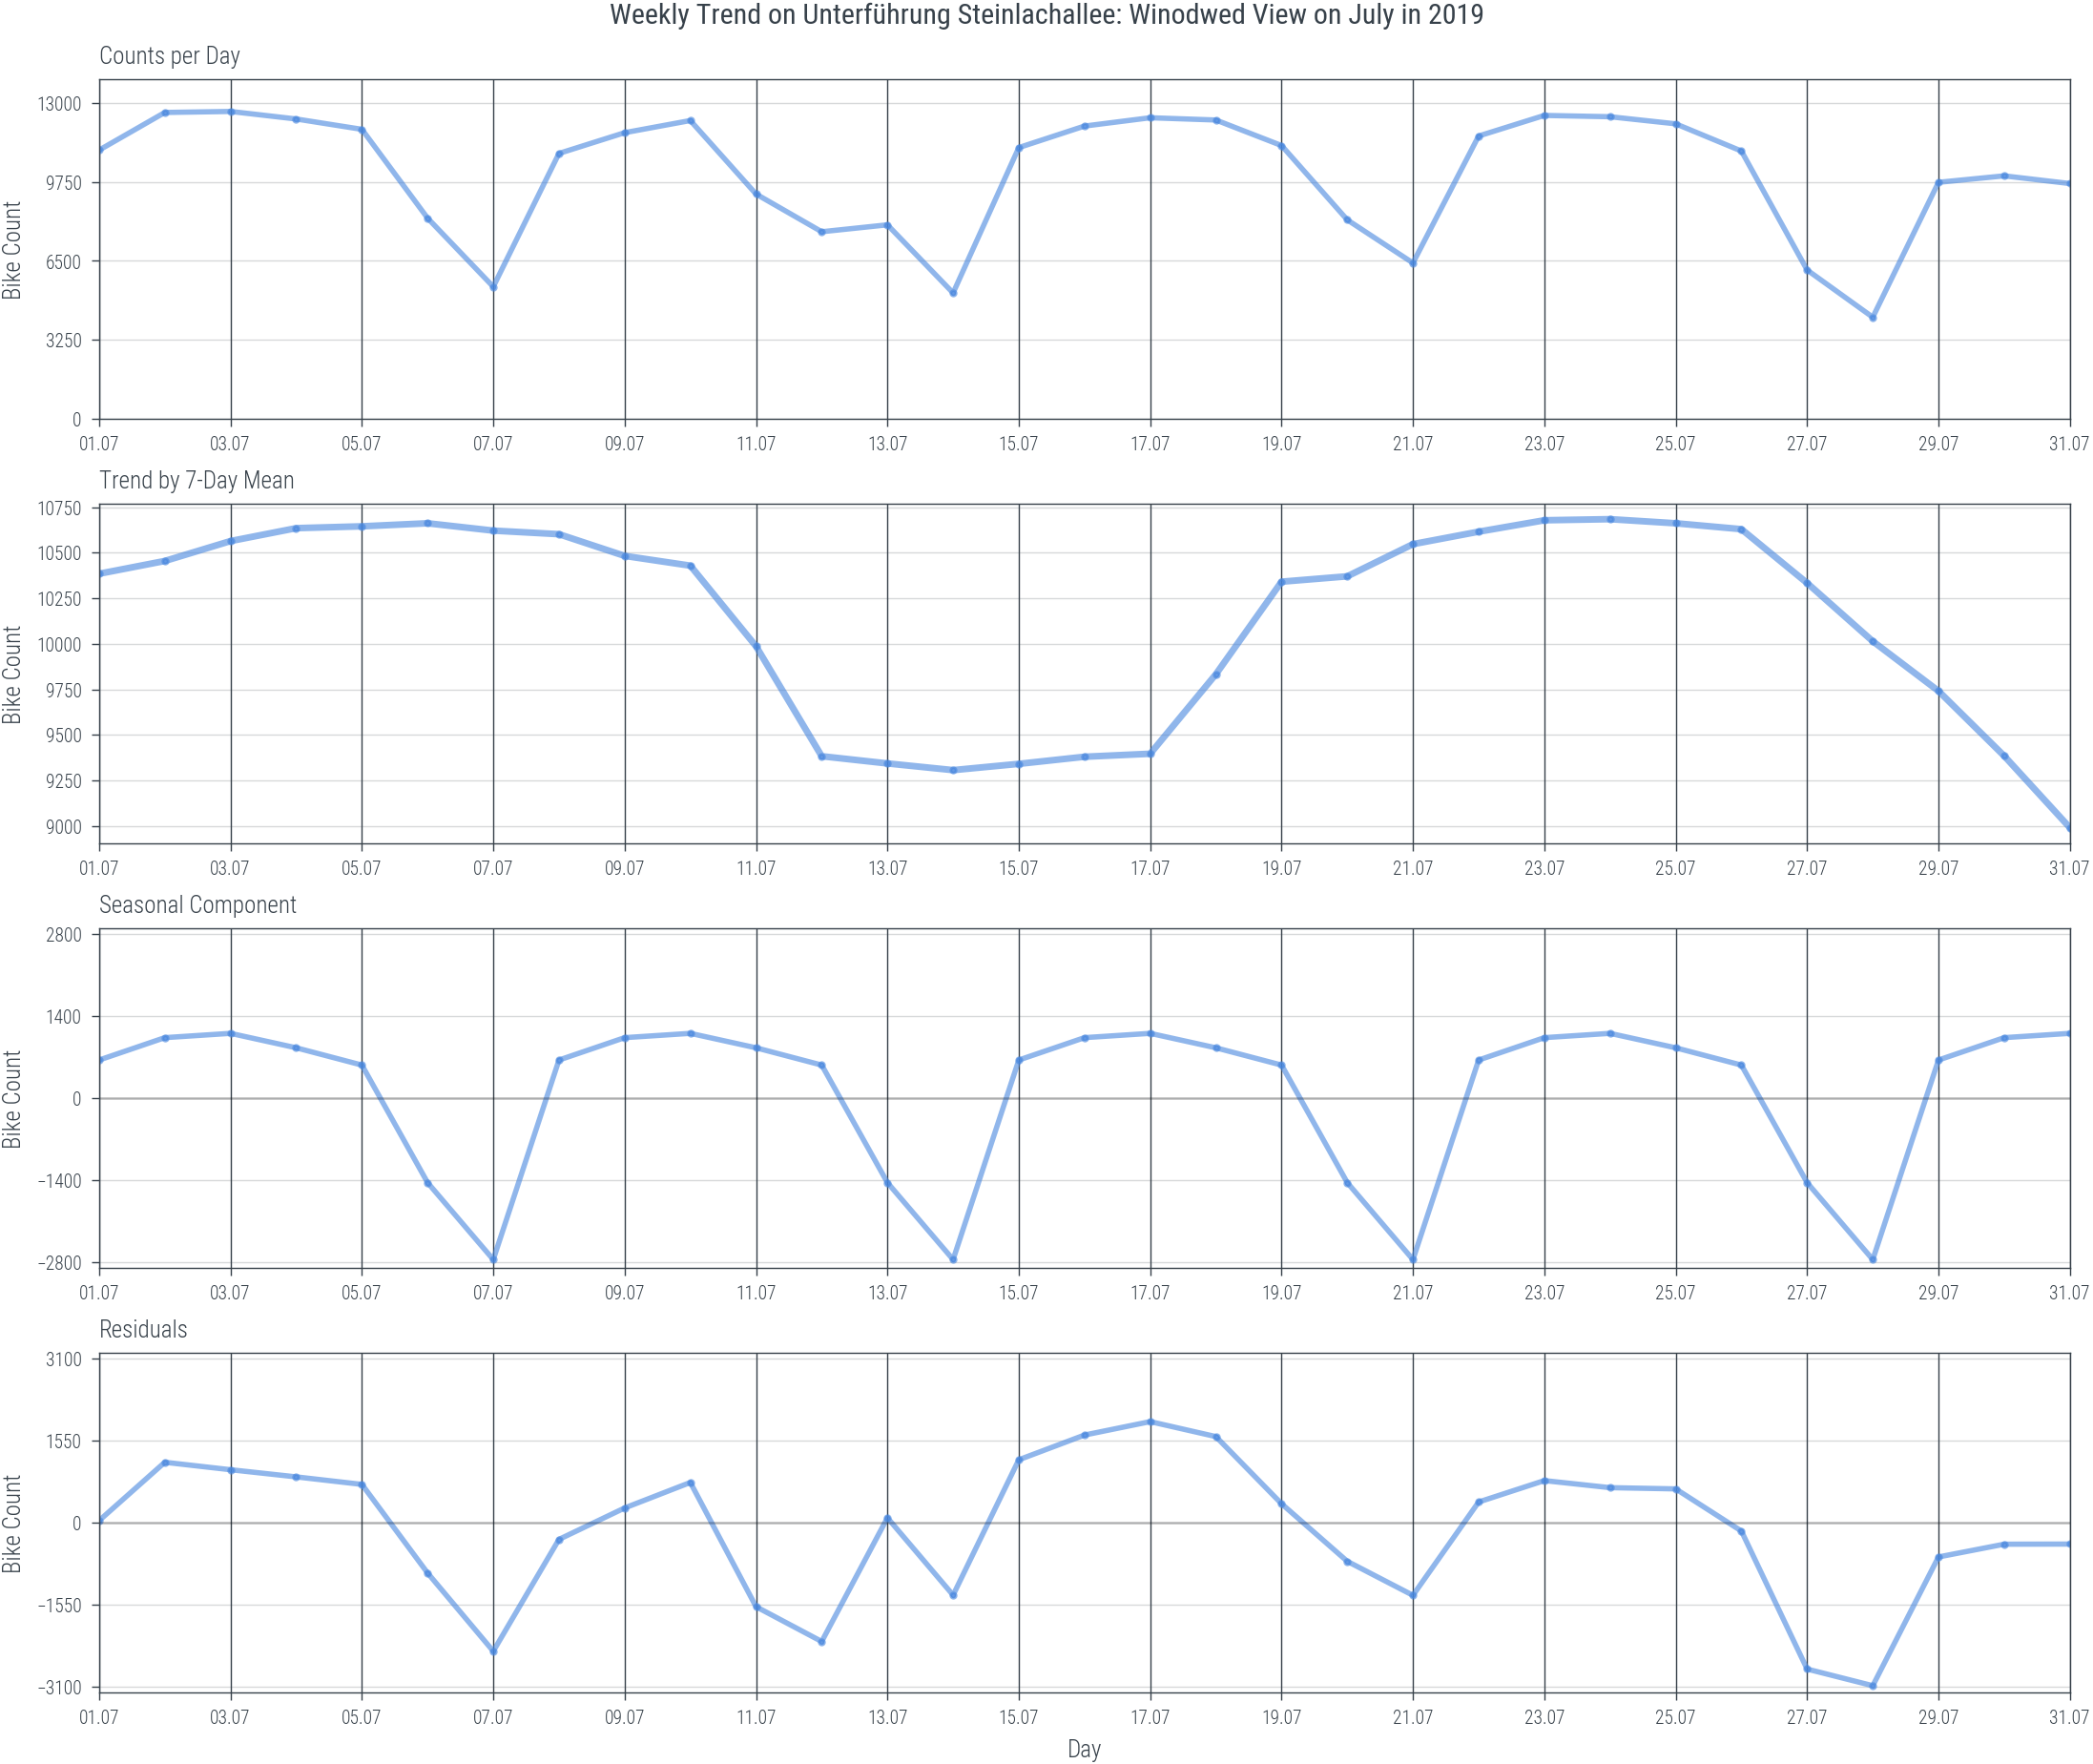

In [15]:
# Steinlach
create_seasonal_decomposition(STYLE_4_SUBS, counter_id=[100003359], weekly_window=month_to_look_at, residuals=True)

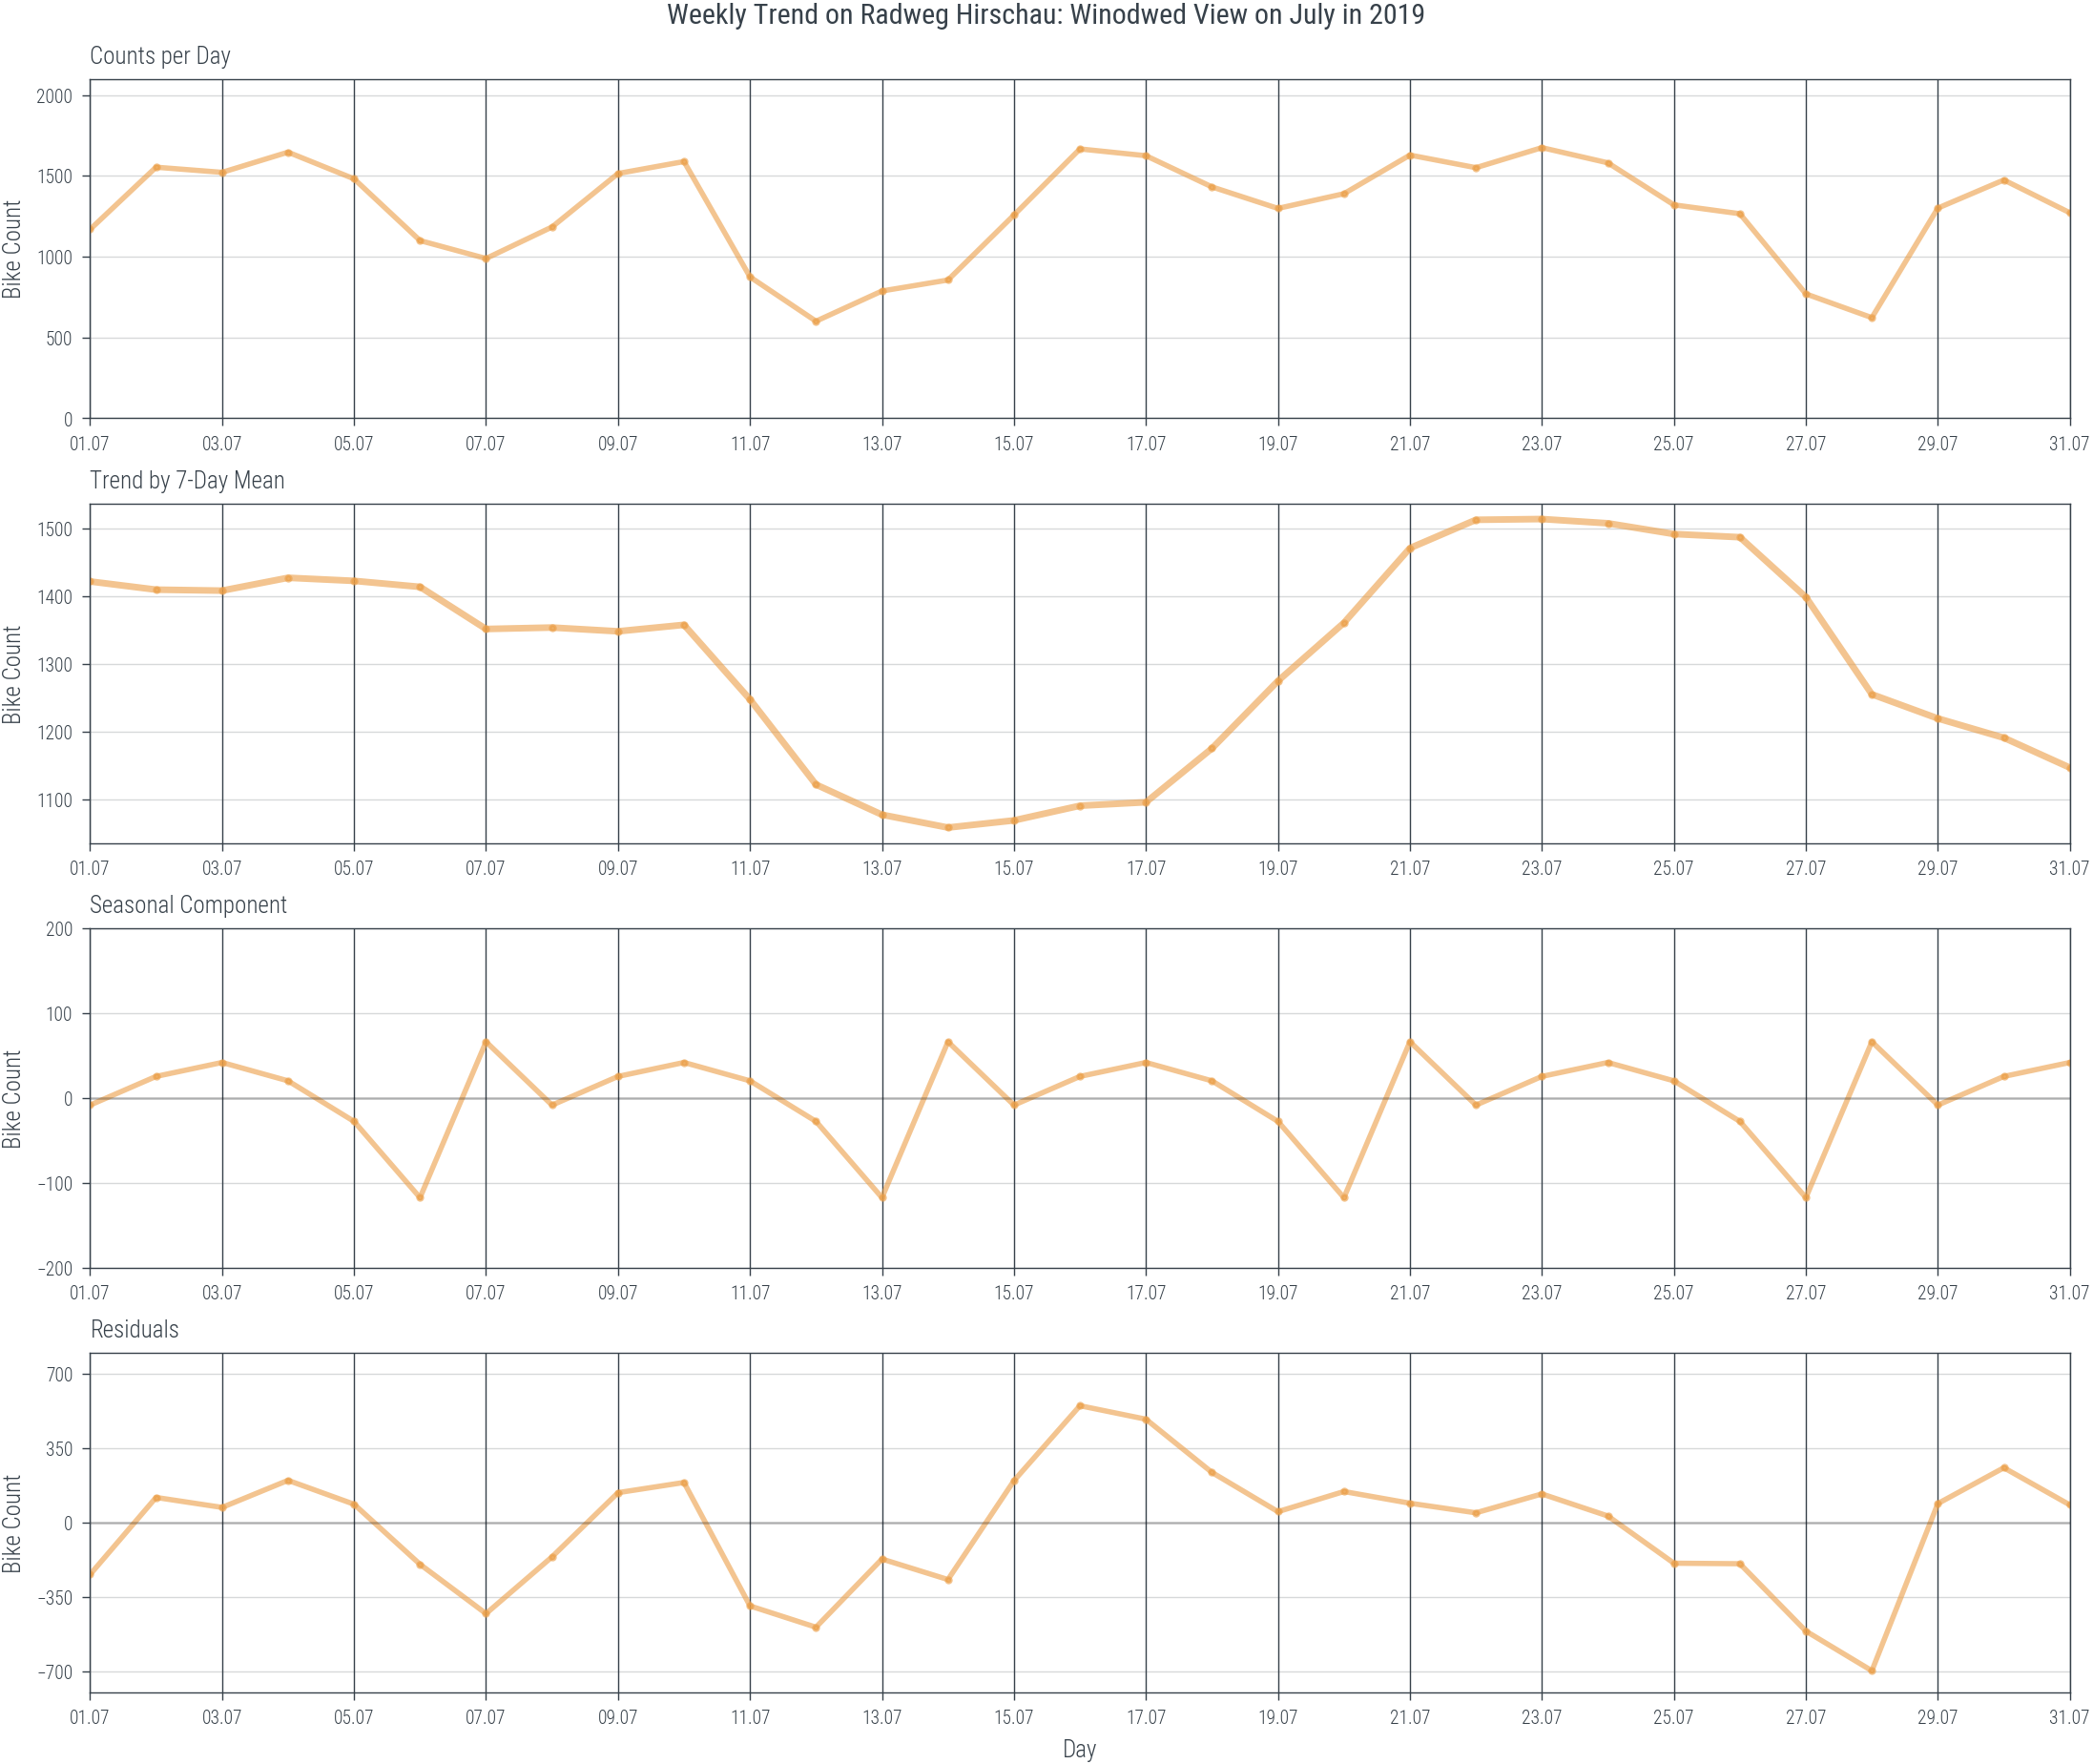

In [16]:
# Hirschau
create_seasonal_decomposition(STYLE_4_SUBS, counter_id=[100026408], weekly_window=month_to_look_at, residuals=True)

__Observation:__
- the weekly trend of Fahrradtunnel and Steinlachallee appears to be the same. It is much higher on weekdays than on weekend
- Hirschau shows huge difference, as Sundays show a huge spike in the data

Let's do the correlation comparison analysis on the merged data again for a weekly period window. 

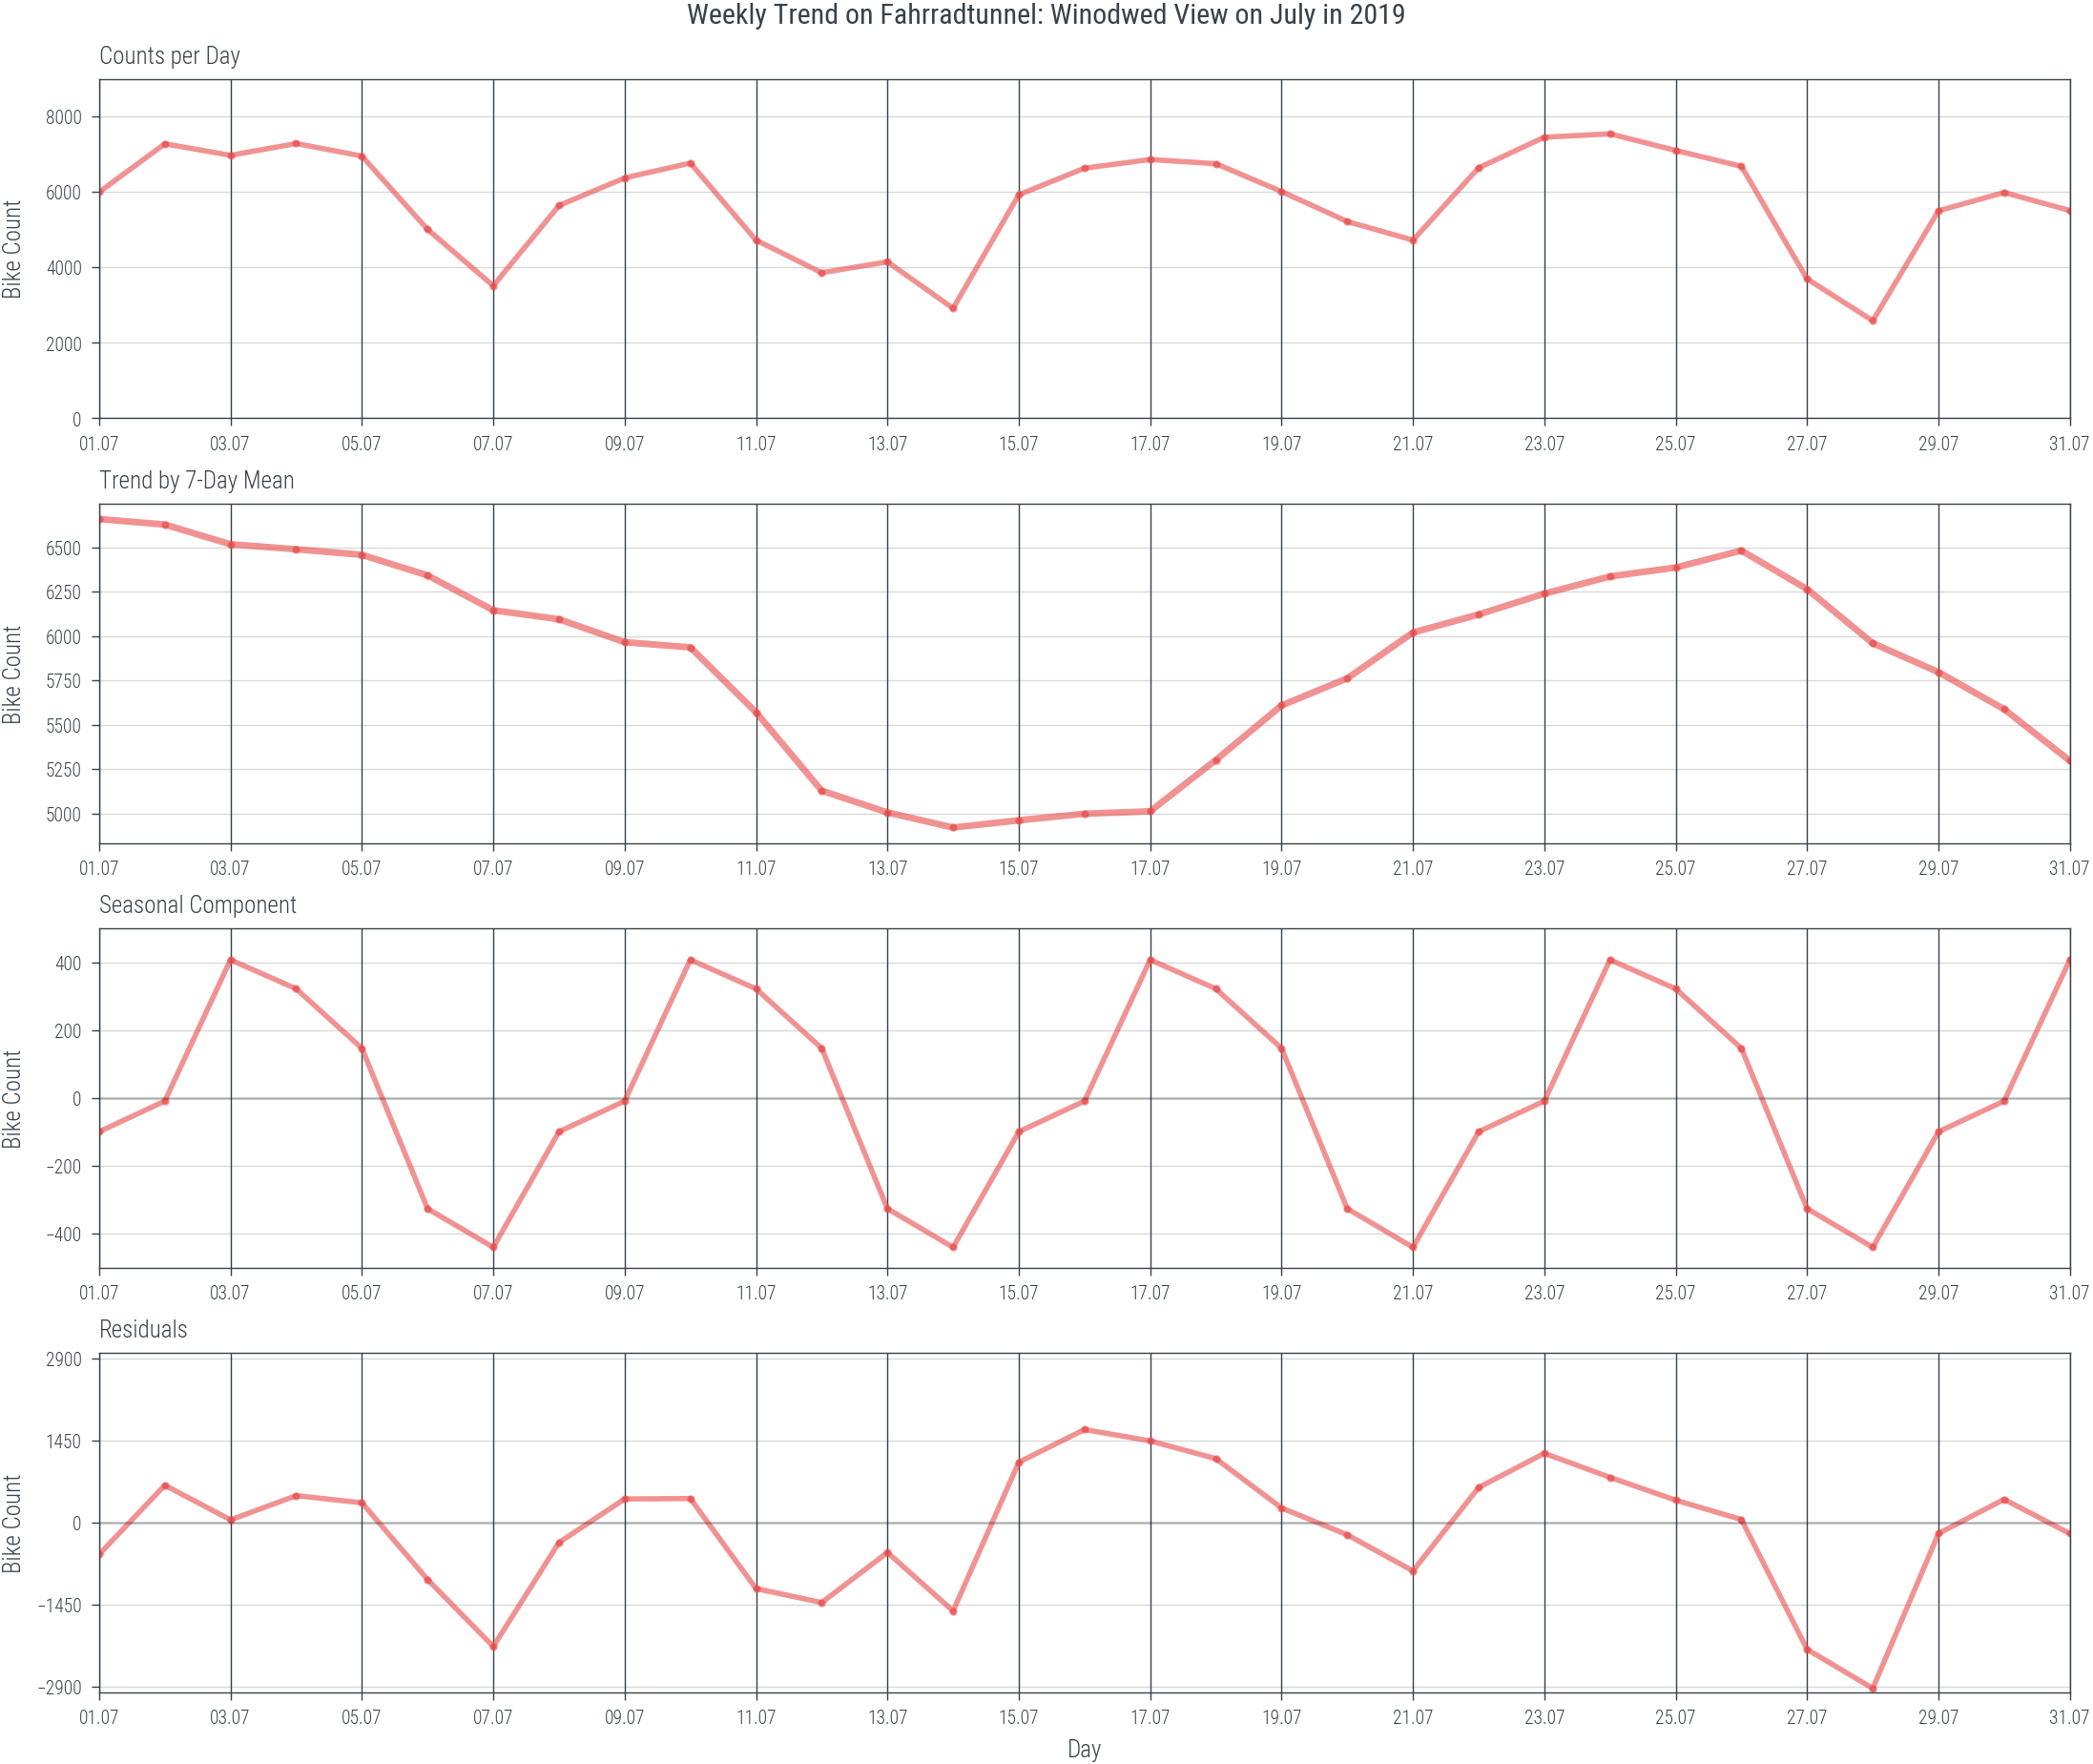

In [17]:
# Fahrradtunnel
merged_bike_data = reset()
create_seasonal_decomposition(STYLE_4_SUBS, counter_id=[100003358], weekly_window=month_to_look_at, custom_data=merged_bike_data, residuals=True)

In [18]:
merged_bike_data = reset()
components_tunnel = seasonal_decompose(merged_bike_data["zählstand_tunnel"], model='additive', period=7, two_sided=False)
components_steinlachallee = seasonal_decompose(merged_bike_data["zählstand_steinlach"], model='additive', period=7, two_sided=False)
components_hirschau = seasonal_decompose(merged_bike_data["zählstand_hirschau"], model='additive', period=7, two_sided=False)

cc_tunnel_steinlach, p_tunnel_steinlach = pearsonr(components_tunnel.seasonal, components_steinlachallee.seasonal)
cc_tunnel_hirschau, p_tunnel_hirschau = pearsonr(components_tunnel.seasonal, components_hirschau.seasonal)
cc_steinlach_hirschau, p_steinlach_hirschau = pearsonr(components_steinlachallee.seasonal, components_hirschau.seasonal)

print(f"Pearson Correlation Coefficient between Fahrradtunnel and Steinlachallee:\t\t{cc_tunnel_steinlach}\t p-value: {p_tunnel_steinlach}")
print(f"Pearson Correlation Coefficient between Fahrradtunnel and Hirschau:\t\t\t{cc_tunnel_hirschau}\t p-value: {p_tunnel_hirschau}")
print(f"Pearson Correlation Coefficient between Steinlachallee and Hirschau\t\t\t{cc_steinlach_hirschau}\t p-value: {p_steinlach_hirschau}")

Pearson Correlation Coefficient between Fahrradtunnel and Steinlachallee:		0.9945838253830984	 p-value: 0.0
Pearson Correlation Coefficient between Fahrradtunnel and Hirschau:			0.3867185052028228	 p-value: 5.4373305922522655e-92
Pearson Correlation Coefficient between Steinlachallee and Hirschau			0.3004051425265326	 p-value: 1.7613790596915886e-54


__Observation:__
- the correlation coefficient between Fahrradtunnel and Steinlachallee seasonal components for weekly pattern is 0.99 and correlates very strongly
- the comparison to Hirschau shows weak correlation in both cases. This could be explained by the fact, that the weekly trend of Hirschau is focused on Sundays, while the other two counters show a higher trend on weekdays

## Overall Observations and Conclusion

- the trend over all years is increasing for all counters, more people are using bikes. To find a single reason for this is not possible, as there are many factors that might have an influence on this trend. A few obvious influences are the [increasing population of Tübingen](https://www.statistik-bw.de/BevoelkGebiet/Bevoelkerung/01515020.tab?R=GS416041), the subvention of [e-bikes](https://www.swtue.de/service/foerderprogramme/e-mobilitaet.html) and ["Lastenfahrräder"](https://www.tuebingen.de/tuebingen-macht-blau/33172.html) and the extension of the [bike lane network](https://www.tuebingen.de/radverkehrskonzept#/38178)
- the seasonal trend of a year is defined by summer and winter, as the counts increase from January to the end of July and start to decrease after until the end of the year. Fixed school breaks, i.e. periods that are determined by specific dates or holidays, like the start of the summer break (last week in July), autumn break (the week of November the 1st) and winter break (the two weeks from December 24th to January 6th), influence the seasonal trend strongly. School breaks that are not fixed, like easter and whitsun, are not visible in the seasonal trend
- the data of Fahrradtunnel and Steinlachallee behave similar, as they are located in the city center. Both show a very strong correlation
- the weekly trend of both counters is focused on weekdays, as the counts are higher on weekdays than on weekends. This is likely explained by the fact that the counters are located on a popular bike route to the city center. People use this route to get to work or to go shopping
- the data of Hirschau differs from the other two counters, most likely due to its location being farther outside the city. The yearly seasonal trend of Hirschau is focused on summer months, as the counter is located on a popular bike route to the "Schönbuch" forest. The weekly trend of Hirschau shows a huge spike on Sundays, as many people use this route for a bike trip on the weekend
- from the correlation analysis of the observed data and seasonal trends (yearly and weekly) we derive, that _we can combine the data of Fahrradtunnel and Steinlachallee_ by average to one counter, as the data is very similar. This might correct downtimes of counters to provide a continuous time series 
- the data of Hirschau should be analyzed separately, as it differs from the other two counters

__Further Questions:__
- we need to further analyze a week. How do the weekdays differ from each other? How strong is the difference from weekdays to weekends? Is there a visible difference from summer to winter in the count ratio of weekdays to weekends?
- can we derive a typical weekday and weekend day?
- what is the hourly trend of a weekday and weekend day?